# BERTSUM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install rouge-score

In [ ]:
pip install transformers

     |████████████████████████████████| 3.8 MB 8.4 MB/s 
     |████████████████████████████████| 596 kB 43.2 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 6.5 MB 61.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
os.chdir('/content/drive/MyDrive/015GithubRepos/wanted_pre_onboarding/기업과제/project4')
import pandas as pd
import re
import numpy as np
import copy

# torch
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_

from transformers import BertModel, BertConfig, AutoModel, AutoTokenizer, AutoConfig, AdamW
from transformers.optimization import get_linear_schedule_with_warmup

from torch.utils.data import DataLoader, Dataset
from torch.nn.init import xavier_uniform_

from sklearn.model_selection import train_test_split, KFold

from rouge_score import rouge_scorer

# from models.decoder import TransformerDecoder
# from models.encoder import Classifier, ExtTransformerEncoder
# from models.optimizers import Optimizer

## 초기설정

### version

In [ ]:
version = 'v05'
os.makedirs(version, exist_ok=True)

### tokenizer

In [ ]:
# model = AutoModel.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

###device

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


## 데이터 불러오기

In [ ]:
df_original = pd.read_csv("clova_data_final_0323.csv")
df_aihub = pd.read_csv("aihub_total_5564_bertsum.csv")
df = pd.concat([df_original, df_aihub])
df.reset_index(drop=True, inplace=True)
df

,index,TITLE,CONTENT,LABEL,SUMMARY_IDX,SUMMARY_ONEHOT_IDX,LABEL_CNT
0,0.0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,"[0, 9, 11]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",3.0
1,1.0,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,"[0, 8, 12]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.0
2,2.0,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"[0, 1, 8]","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",3.0
3,3.0,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,"[0, 21, 25]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0
4,4.0,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"[2, 3, 12]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3.0
...,...,...,...,...,...,...,...
12634,NaN,NaN,성남문화재단(대표 박명숙)이 새로운 전시공간 윈도우갤러리에서 마을과 마을을 문화로 ...,성남문화재단(대표 박명숙)이 새로운 전시공간 윈도우갤러리에서 마을과 마을을 문화로 ...,"[0, 1, 2]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN
12635,NaN,NaN,경기콘텐츠진흥원은 경기북부 소재 6개 대학과 '경기북부 지역기반 창업지원 인프라 조...,경기콘텐츠진흥원은 경기북부 소재 6개 대학과 '경기북부 지역기반 창업지원 인프라 조...,"[0, 2, 5]","[1, 0, 1, 0, 0, 1, 0, 0]",NaN
12636,NaN,NaN,관세조사 과정에서 납세자의 권리를 보호하기 위해 납세자보호관과 납세자보호위원회를 도...,관세조사 과정에서 납세자의 권리를 보호하기 위해 납세자보호관과 납세자보호위원회를 도...,"[0, 1, 5]","[1, 1, 0, 0, 0, 1, 0, 0, 0]",NaN
12637,NaN,NaN,한선교 의원의 사무총장 사퇴 11일 만에 자유한국당이 새 사무총장으로 재선의 박맹우...,한선교 의원의 사무총장 사퇴 11일 만에 자유한국당이 새 사무총장으로 재선의 박맹우...,"[0, 1, 2]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]",NaN


In [ ]:
df['SUMMARY_ONEHOT_IDX'] = df['SUMMARY_ONEHOT_IDX'].map(lambda x: eval(x))

In [ ]:
def get_src_new_idx(doc, label_idx):  # 데이터 하나에 대해서
    src = []
    new_idx = []
    seg = []
    seg_idx = 0

    for si, s in enumerate(doc.split('\t')):
        tokens = tokenizer.encode(s)
        if (len(src) + len(tokens)) > 512:
            break
        else:
            src.extend(tokens)
            new_idx.append(label_idx[si])
            seg.extend([seg_idx] * len(tokens))
            seg_idx = (1, 0)[seg_idx]

    return src, new_idx, seg

In [ ]:
src = []
new_idx = []
seg = []
for _ in range(df.shape[0]):
    src_one, new_idx_one, seg_one = get_src_new_idx(df.loc[_]['CONTENT'], df.loc[_]['SUMMARY_ONEHOT_IDX'])
    src.append(src_one)
    new_idx.append(new_idx_one)
    seg.append(seg_one)

In [ ]:
df['src'] = src
df['new_idx'] = new_idx
df['seg'] = seg

In [ ]:
df

,index,TITLE,CONTENT,LABEL,SUMMARY_IDX,SUMMARY_ONEHOT_IDX,LABEL_CNT,src,new_idx,seg
0,0.0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,"[0, 9, 11]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",3.0,"[2, 4227, 20212, 12, 24697, 13, 7084, 7330, 63...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1.0,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,"[0, 8, 12]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7084, 7330, 2145, 1726, 2160, 9583, 17482,...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2.0,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"[0, 1, 8]","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 1244, 4161, 2052, 3670, 31302, 2119, 1537,...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3.0,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,"[0, 21, 25]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 1929, 13744, 1757, 1469, 2472, 5367, 2264,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4.0,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"[2, 3, 12]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7992, 12731, 2116, 1244, 4161, 7446, 11300...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...,...,...,...
12634,NaN,NaN,성남문화재단(대표 박명숙)이 새로운 전시공간 윈도우갤러리에서 마을과 마을을 문화로 ...,성남문화재단(대표 박명숙)이 새로운 전시공간 윈도우갤러리에서 마을과 마을을 문화로 ...,"[0, 1, 2]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN,"[2, 6406, 19611, 2286, 12, 3661, 17490, 2300, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12635,NaN,NaN,경기콘텐츠진흥원은 경기북부 소재 6개 대학과 '경기북부 지역기반 창업지원 인프라 조...,경기콘텐츠진흥원은 경기북부 소재 6개 대학과 '경기북부 지역기반 창업지원 인프라 조...,"[0, 2, 5]","[1, 0, 1, 0, 0, 1, 0, 0]",NaN,"[2, 3682, 2435, 5051, 20505, 2252, 2073, 3682,...","[1, 0, 1, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12636,NaN,NaN,관세조사 과정에서 납세자의 권리를 보호하기 위해 납세자보호관과 납세자보호위원회를 도...,관세조사 과정에서 납세자의 권리를 보호하기 위해 납세자보호관과 납세자보호위원회를 도...,"[0, 1, 5]","[1, 1, 0, 0, 0, 1, 0, 0, 0]",NaN,"[2, 7258, 12933, 3747, 27135, 20321, 2079, 511...","[1, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12637,NaN,NaN,한선교 의원의 사무총장 사퇴 11일 만에 자유한국당이 새 사무총장으로 재선의 박맹우...,한선교 의원의 사무총장 사퇴 11일 만에 자유한국당이 새 사무총장으로 재선의 박맹우...,"[0, 1, 2]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]",NaN,"[2, 1891, 2020, 2120, 3712, 2079, 8310, 6336, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df['mask_src'] = df['src'].map(lambda x: [1] * len(x))

In [ ]:
df['clss'] = df['src'].map(lambda x: [ti for ti, t in enumerate(x) if t == tokenizer.cls_token_id])
df['mask_cls'] = df['clss'].map(lambda x: [1] * len(x))

In [ ]:
df

,index,TITLE,CONTENT,LABEL,SUMMARY_IDX,SUMMARY_ONEHOT_IDX,LABEL_CNT,src,new_idx,seg,mask_src,clss,mask_cls
0,0.0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,"[0, 9, 11]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",3.0,"[2, 4227, 20212, 12, 24697, 13, 7084, 7330, 63...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38, 64, 77, 87, 126, 138, 156, 185, 198, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1.0,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,"[0, 8, 12]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7084, 7330, 2145, 1726, 2160, 9583, 17482,...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 20, 45, 68, 92, 105, 124, 140, 169, 200, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2.0,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"[0, 1, 8]","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 1244, 4161, 2052, 3670, 31302, 2119, 1537,...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 22, 62, 72, 99, 113, 128, 154, 164, 191, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3.0,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,"[0, 21, 25]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 1929, 13744, 1757, 1469, 2472, 5367, 2264,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 21, 39, 53, 71, 78, 106, 135, 162, 190, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4.0,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"[2, 3, 12]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7992, 12731, 2116, 1244, 4161, 7446, 11300...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 14, 25, 55, 85, 95, 135, 144, 162, 190, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12634,NaN,NaN,성남문화재단(대표 박명숙)이 새로운 전시공간 윈도우갤러리에서 마을과 마을을 문화로 ...,성남문화재단(대표 박명숙)이 새로운 전시공간 윈도우갤러리에서 마을과 마을을 문화로 ...,"[0, 1, 2]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN,"[2, 6406, 19611, 2286, 12, 3661, 17490, 2300, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 50, 136, 170, 228, 262, 294, 390, 459]","[1, 1, 1, 1, 1, 1, 1, 1, 1]"
12635,NaN,NaN,경기콘텐츠진흥원은 경기북부 소재 6개 대학과 '경기북부 지역기반 창업지원 인프라 조...,경기콘텐츠진흥원은 경기북부 소재 6개 대학과 '경기북부 지역기반 창업지원 인프라 조...,"[0, 2, 5]","[1, 0, 1, 0, 0, 1, 0, 0]",NaN,"[2, 3682, 2435, 5051, 20505, 2252, 2073, 3682,...","[1, 0, 1, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38, 101, 204, 239, 304, 373, 423]","[1, 1, 1, 1, 1, 1, 1, 1]"
12636,NaN,NaN,관세조사 과정에서 납세자의 권리를 보호하기 위해 납세자보호관과 납세자보호위원회를 도...,관세조사 과정에서 납세자의 권리를 보호하기 위해 납세자보호관과 납세자보호위원회를 도...,"[0, 1, 5]","[1, 1, 0, 0, 0, 1, 0, 0, 0]",NaN,"[2, 7258, 12933, 3747, 27135, 20321, 2079, 511...","[1, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 34, 74, 110

## train과 dev로 나눔

In [ ]:
train_df = df.iloc[2000:]
dev_df = df.iloc[:2000]

In [ ]:
train_df

,index,TITLE,CONTENT,LABEL,SUMMARY_IDX,SUMMARY_ONEHOT_IDX,LABEL_CNT,src,new_idx,seg,mask_src,clss,mask_cls
2000,2001.0,"[오피셜] 토트넘 산투, EPL 이달의 감독상 수상...'리그 전승+선두'",토트넘 홋스퍼의 누누 에스피리투 산투 감독이 잉글리시 프리미어리그(EPL) 8월 이...,토트넘 홋스퍼의 누누 에스피리투 산투 감독이 잉글리시 프리미어리그(EPL) 8월 이...,"[0, 1, 4]","[1, 1, 0, 0, 1, 0, 0]",3.0,"[2, 20482, 1, 778, 2416, 5493, 2263, 2059, 231...","[1, 1, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 32, 65, 77, 103, 128, 144]","[1, 1, 1, 1, 1, 1, 1]"
2001,2002.0,"유망주 골키퍼가 본 SON 선배, “항상 웃고 행복한 사람!”",유망주 골키퍼 알피 화이트먼(데게르포르스 IF)이 바라본 손흥민(토트넘 홋스퍼)은 ...,유망주 골키퍼 알피 화이트먼(데게르포르스 IF)이 바라본 손흥민(토트넘 홋스퍼)은 ...,"[0, 2, 3]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 16993, 13038, 1381, 2263, 7482, 2615, 12, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 30, 54, 75, 92, 104, 149, 171, 193, 203, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2002,2003.0,"“정말 아름다운 밤”… 메시, 볼리비아전 대승 후 눈물 흘린 사연",리오넬 메시가 그간의 서러움을 털었다.\t볼리비아전 완승 이후 기쁨의 눈물을 흘렸다...,이날 아르헨티나는 경기 후 코파 아메리카 우승을 축하하는 시간을 마련했다.\t여러모...,"[5, 12, 15]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 14628, 2829, 5136, 2116, 7644, 2079, 1258,...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 15, 28, 57, 81, 122, 143, 181, 206, 222, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2003,2004.0,"'아직 현역이었네' 맨유 출신 젬바-젬바, 40살에 현역 은퇴 선언",추억의 선수 에릭 젬바젬바가 현역 은퇴를 선언했다.\t영국 매체 '트라이벌 풋볼'은...,추억의 선수 에릭 젬바젬바가 현역 은퇴를 선언했다.\t카메룬 출신인 젬바젬바는 프랑...,"[0, 3, 6]","[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 6469, 2079, 3825, 13300, 1, 8633, 6879, 21...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 14, 43, 58, 77, 98, 111, 134, 153, 181, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2004,2005.0,[현장핫피플] “긴장했을 텐데”… 00년생 추상훈의 ‘짧지만 강렬했던 데뷔전’,추상훈(제주 유나이티드)이 프로 데뷔전에서 눈부신 활약을 펼쳤다.\t제주는 11일 ...,추상훈(제주 유나이티드)이 프로 데뷔전에서 눈부신 활약을 펼쳤다.\t경기 후 남 감...,"[0, 20, 27]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 9348, 2034, 12, 4364, 13791, 2343, 13, 150...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 20, 64, 87, 100, 120, 143, 163, 175, 199, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12634,NaN,NaN,성남문화재단(대표 박명숙)이 새로운 전시공간 윈도우갤러리에서 마을과 마을을 문화로 ...,성남문화재단(대표 박명숙)이 새로운 전시공간 윈도우갤러리에서 마을과 마을을 문화로 ...,"[0, 1, 2]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",NaN,"[2, 6406, 19611, 2286, 12, 3661, 17490, 2300, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 50, 136, 170, 228, 262, 294, 390, 459]","[1, 1, 1, 1, 1, 1, 1, 1, 1]"
12635,NaN,NaN,경기콘텐츠진흥원은 경기북부 소재 6개 대학과 '경기북부 지역기반 창업지원 인프라 조...,경기콘텐츠진흥원은 경기북부 소재 6개 대학과 '경기북부 지역기반 창업지원 인프라 조...,"[0, 2, 5]","[1, 0, 1, 0, 0, 1, 0, 0]",NaN,"[2, 3682, 2435, 5051, 20505, 2252, 2073, 3682,...","[1, 0, 1, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38, 101, 204, 239, 304, 373, 423]","[1, 1, 1, 1, 1, 1, 1, 1]"
12636,NaN,NaN,관세조사 과정에서 납세자의 권리를 보호하기 위해 납세자보호관과 납세자보호위원회를 도...,관세조사 과정에서 납세자의 권리를 보호하기 위해 납세자보호관과 납세자보호위원회를 도...,"[0, 1, 5]","[1, 1, 0, 0, 0, 1, 0, 0, 0]",NaN,"[2, 7258, 12933, 3747, 27135, 20321, 2079, 511...","[1, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 34, 74, 110, 129, 207, 246, 270, 318]","[1, 1, 1, 1, 1, 1, 1, 1, 1]"
12637,

In [ ]:
dev_df

,index,TITLE,CONTENT,LABEL,SUMMARY_IDX,SUMMARY_ONEHOT_IDX,LABEL_CNT,src,new_idx,seg,mask_src,clss,mask_cls
0,0.0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,"[0, 9, 11]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",3.0,"[2, 4227, 20212, 12, 24697, 13, 7084, 7330, 63...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38, 64, 77, 87, 126, 138, 156, 185, 198, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1.0,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,"[0, 8, 12]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7084, 7330, 2145, 1726, 2160, 9583, 17482,...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 20, 45, 68, 92, 105, 124, 140, 169, 200, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2.0,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"[0, 1, 8]","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 1244, 4161, 2052, 3670, 31302, 2119, 1537,...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 22, 62, 72, 99, 113, 128, 154, 164, 191, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3.0,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,"[0, 21, 25]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 1929, 13744, 1757, 1469, 2472, 5367, 2264,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 21, 39, 53, 71, 78, 106, 135, 162, 190, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4.0,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"[2, 3, 12]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7992, 12731, 2116, 1244, 4161, 7446, 11300...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 14, 25, 55, 85, 95, 135, 144, 162, 190, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996.0,"[현장목소리] 울산 만나는 김상식 감독, “벼랑 끝 심정, 위기이자 기회다”",전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다.\t전북...,전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다.\t김상...,"[0, 9, 17]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",3.0,"[2, 6275, 3845, 8008, 2096, 3871, 2052, 4595, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 24, 56, 76, 83, 95, 117, 138, 156, 175, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1996,1997.0,“크로스 올리면 네이마르보다 위협적”… ‘리그 4골’ 공격수 품은 이유,FC 바르셀로나 로날드 쿠만 감독이 신입생 루크 데 용을 품은 이유를 밝혔다.\t바...,바르사는 이적 시장 마지막 날에 데 용을 데려왔다.\t하지만 쿠만 감독은 데 용 활...,"[1, 8, 12]","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7992, 12731, 991, 18508, 1738, 2154, 3871,...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 23, 39, 65, 81, 98, 115, 141, 153, 171, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1997,1998.0,"[현장목소리] 홍명보 감독, “전북 상대로 우리 경쟁력 가늠할 경기”",울산 현대 홍명보 감독이 전북 현대와 103번째 현대가더비를 반드시 승리하겠다고 밝...,"사전 기자회견에 나선 홍명보 감독은 ""우리도 전북도 굉장히

## 인풋 형태

In [ ]:
'''
인풋 형태

2 : [CLS]
3 : [SEP]

1. src  # 토큰 =================================================================
[
 [2, 545, ...3, 2, 34, 23, ..., 3]  # 문장의 개수가 5개라고 가정
 [2, 236, 45,..., 3, 2, 3463, 4546, 545, ..., 3]  # 문장의 개수가 10개라고 가정
 ...
]

2. segs  # segment embedding ===================================================
[
 [0, 0, ...0, 1, 1, 1, ..., 1]
 [0, 0, 0, ...,0, 1, 1, 1, 1, ..., 1]
 ...
]

3. mask_src  # attention mask. collate function에서 패딩됨 =====================
[
 [1, 1, ...1, 1, 1, 1, ..., 1]
 [1, 1, 1, ...,1, 1, 1, 1, 1, ..., 1]
 ...
]

※ 1~3은 BERT에 입력됨. tokenizer의 아웃풋과 동일한 형태임.


4. clss # [CLS]토큰의 위치======================================================
[
 [0, 5, 33, 102, 145]  
 [0, 13, 56, 79, 166, 197, 255, 276, 300, 342]
 ...
]

5. mask_cls  # clss만큼 1로 채워짐. collate function에서 패딩됨=================
[
 [1, 1, 1, 1, 1]  # 문장개수 5개일 때
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # 문장개수 10개일 때
 ...
]

6. src_sent_labels_list   # label문장의 위치. loss function에서 사용됨==========
[
 [0, 1, 1, 0, 0]  # 문장개수 5, 정답라벨 2개일 때
 [0, 1, 0, 0, 1, 1, 0, 0, 0, 0]  # 문장개수 10, 정답라벨 3개일 때
 ...
]
'''

'\n인풋 형태\n\n2 : [CLS]\n3 : [SEP]\n\n1. src  # 토큰 =================================================================\n[\n [2, 545, ...3, 2, 34, 23, ..., 3]  # 문장의 개수가 5개라고 가정\n [2, 236, 45,..., 3, 2, 3463, 4546, 545, ..., 3]  # 문장의 개수가 10개라고 가정\n ...\n]\n\n2. segs  # segment embedding ===================================================\n[\n [0, 0, ...0, 1, 1, 1, ..., 1]\n [0, 0, 0, ...,0, 1, 1, 1, 1, ..., 1]\n ...\n]\n\n3. mask_src  # attention mask. collate function에서 패딩됨 =====================\n[\n [1, 1, ...1, 1, 1, 1, ..., 1]\n [1, 1, 1, ...,1, 1, 1, 1, 1, ..., 1]\n ...\n]\n\n※ 1~3은 BERT에 입력됨. tokenizer의 아웃풋과 동일한 형태임.\n\n\n4. clss # [CLS]토큰의 위치======================================================\n[\n [0, 5, 33, 102, 145]  \n [0, 13, 56, 79, 166, 197, 255, 276, 300, 342]\n ...\n]\n\n5. mask_cls  # clss만큼 1로 채워짐. collate function에서 패딩됨=================\n[\n [1, 1, 1, 1, 1]  # 문장개수 5개일 때\n [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # 문장개수 10개일 때\n ...\n]\n\n6. src_sent_labels_list   # label문장의 위치

## 끝났다!

# 학습

## args

In [ ]:
import argparse

def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
parser = argparse.ArgumentParser()

parser.add_argument("-task", default='ext', type=str, choices=['ext', 'abs'])
parser.add_argument("-encoder", default='bert', type=str, choices=['bert', 'baseline'])
parser.add_argument("-mode", default='train', type=str, choices=['train', 'validate', 'test'])
parser.add_argument("-bert_data_path", default='../bert_data_new/cnndm')
parser.add_argument("-model_path", default='../models/')
parser.add_argument("-result_path", default='../results/cnndm')
parser.add_argument("-temp_dir", default='../temp')

parser.add_argument("-batch_size", default=140, type=int)
parser.add_argument("-test_batch_size", default=200, type=int)

parser.add_argument("-max_pos", default=512, type=int)
parser.add_argument("-use_interval", type=str2bool, nargs='?',const=True,default=True)
parser.add_argument("-large", type=str2bool, nargs='?',const=True,default=False)
parser.add_argument("-load_from_extractive", default='', type=str)

parser.add_argument("-sep_optim", type=str2bool, nargs='?',const=True,default=False)
parser.add_argument("-lr_bert", default=2e-3, type=float)
parser.add_argument("-lr_dec", default=2e-3, type=float)
parser.add_argument("-use_bert_emb", type=str2bool, nargs='?',const=True,default=False)

parser.add_argument("-share_emb", type=str2bool, nargs='?', const=True, default=False)
parser.add_argument("-finetune_bert", type=str2bool, nargs='?', const=True, default=True)
parser.add_argument("-dec_dropout", default=0.2, type=float)
parser.add_argument("-dec_layers", default=6, type=int)
parser.add_argument("-dec_hidden_size", default=768, type=int)
parser.add_argument("-dec_heads", default=8, type=int)
parser.add_argument("-dec_ff_size", default=2048, type=int)
parser.add_argument("-enc_hidden_size", default=512, type=int)
parser.add_argument("-enc_ff_size", default=512, type=int)
parser.add_argument("-enc_dropout", default=0.2, type=float)
parser.add_argument("-enc_layers", default=6, type=int)

# params for EXT
parser.add_argument("-ext_dropout", default=0.2, type=float)
parser.add_argument("-ext_layers", default=2, type=int)
parser.add_argument("-ext_hidden_size", default=768, type=int)
parser.add_argument("-ext_heads", default=8, type=int)
parser.add_argument("-ext_ff_size", default=2048, type=int)

parser.add_argument("-label_smoothing", default=0.1, type=float)
parser.add_argument("-generator_shard_size", default=32, type=int)
parser.add_argument("-alpha",  default=0.6, type=float)
parser.add_argument("-beam_size", default=5, type=int)
parser.add_argument("-min_length", default=15, type=int)
parser.add_argument("-max_length", default=150, type=int)
parser.add_argument("-max_tgt_len", default=140, type=int)



parser.add_argument("-param_init", default=0, type=float)
parser.add_argument("-param_init_glorot", type=str2bool, nargs='?',const=True,default=True)
parser.add_argument("-optim", default='adam', type=str)
parser.add_argument("-lr", default=1, type=float)
parser.add_argument("-beta1", default= 0.9, type=float)
parser.add_argument("-beta2", default=0.999, type=float)
parser.add_argument("-warmup_steps", default=8000, type=int)
parser.add_argument("-warmup_steps_bert", default=8000, type=int)
parser.add_argument("-warmup_steps_dec", default=8000, type=int)
parser.add_argument("-max_grad_norm", default=0, type=float)

parser.add_argument("-save_checkpoint_steps", default=5, type=int)
parser.add_argument("-accum_count", default=1, type=int)
parser.add_argument("-report_every", default=1, type=int)
parser.add_argument("-train_steps", default=1000, type=int)
parser.add_argument("-recall_eval", type=str2bool, nargs='?',const=True,default=False)


parser.add_argument('-visible_gpus', default='-1', type=str)
parser.add_argument('-gpu_ranks', default='0', type=str)
parser.add_argument('-log_file', default='../logs/cnndm.log')
parser.add_argument('-seed', default=666, type=int)

parser.add_argument("-test_all", type=str2bool, nargs='?',const=True,default=False)
parser.add_argument("-test_from", default='')
parser.add_argument("-test_start_from", default=-1, type=int)

parser.add_argument("-train_from", default='')
parser.add_argument("-report_rouge", type=str2bool, nargs='?',const=True,default=True)
parser.add_argument("-block_trigram", type=str2bool, nargs='?', const=True, default=True)

args = parser.parse_args([])
args.gpu_ranks = [int(i) for i in range(len(args.visible_gpus.split(',')))]
args.world_size = len(args.gpu_ranks)
os.environ["CUDA_VISIBLE_DEVICES"] = args.visible_gpus
args = parser.parse_args([])

## CustomDataset

In [ ]:
class CustomDataset(Dataset):
  """
  - input_data: list of string
  - target_data: list of int
  """

  def __init__(self, src:list, segs:list, mask_src:list, clss:list, mask_cls:list, labels:list, content:list, label_str:list) -> None:
      self.src = src
      self.segs = segs
      self.mask_src = mask_src
      self.clss = clss
      self.mask_cls = mask_cls
      self.labels = labels
      self.content = content
      self.label_str = label_str

  def __len__(self):
      return len(self.src)

  def __getitem__(self, index):
      return (self.src[index], self.segs[index], self.mask_src[index], self.clss[index], self.mask_cls[index], self.labels[index], self.content[index], self.label_str[index])

## custom_collate_fn

In [ ]:
def custom_collate_fn(batch):

    global tokenizer

    def _pad(data, pad_id, width=-1):
        if (width == -1):
            width = max(len(d) for d in data)
        rtn_data = [d + [pad_id] * (width - len(d)) for d in data]
        return rtn_data
    
    src = [_[0] for _ in batch]
    segs = [_[1] for _ in batch]
    mask_src = [_[2] for _ in batch]
    clss = [_[3] for _ in batch]
    mask_cls = [_[4] for _ in batch]
    labels = [_[5] for _ in batch]

    content = [_[6] for _ in batch]
    label_str = [_[7] for _ in batch]

    # tensor 화
    src = torch.tensor(_pad(src, 0))
    segs = torch.tensor(_pad(segs, 0))
    mask_src = torch.tensor(_pad(mask_src, 0))
    clss = torch.tensor(_pad(clss, 0))
    mask_cls = torch.tensor(_pad(mask_cls, 0))
    labels = torch.tensor(_pad(labels, 0))


    return (src, segs, mask_src, clss, mask_cls, labels, content, label_str)

## 성능계산 함수(배치단위)

In [ ]:
# 성능 계산
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def get_score(scorer, batch_content, selected_ids, batch_label_str, batch_labels):

    batch_rouge1_f = 0
    batch_rouge2_f = 0
    batch_rougeL_f = 0
    batch_intersection_score = 0

    for doc, pred_idxs, true_str, true_positions in zip(batch_content, selected_ids, batch_label_str, batch_labels):
        true_positions = true_positions.detach().cpu().numpy()
        nof_labels = true_positions.sum()
        if nof_labels == 0:
            # print(f'label개수 0!!!')
            continue
        pred_idxs = pred_idxs[:nof_labels]
        pred_str = ' '.join(np.array(doc.split('\t'))[pred_idxs])
        true_str = true_str.replace('\t', ' ')

        rouge1_f = scorer.score(pred_str, true_str)['rouge1'].fmeasure
        rouge2_f = scorer.score(pred_str, true_str)['rouge2'].fmeasure
        rougeL_f = scorer.score(pred_str, true_str)['rougeL'].fmeasure

        true_set = set(np.where(true_positions == 1)[0].tolist())
        pred_idxs_set = set(pred_idxs)
        intersection_score = len(true_set.intersection(pred_idxs_set)) / nof_labels

        batch_rouge1_f += rouge1_f
        batch_rouge2_f += rouge2_f
        batch_rougeL_f += rougeL_f
        batch_intersection_score += intersection_score


    return batch_rouge1_f, batch_rouge2_f, batch_rougeL_f, batch_intersection_score

## ExtSummarizer

In [ ]:
class ExtSummarizer(nn.Module):
    def __init__(self, args, device, checkpoint):
        super(ExtSummarizer, self).__init__()
        self.args = args
        self.device = device
        self.finetune = args.finetune_bert

        # BERT 모델 ############################################################
        # self.bert = Bert(args.large, args.temp_dir, args.finetune_bert)
        # self.bert = BertModel.from_pretrained('bert-base-uncased', cache_dir=args.temp_dir)
        self.bert = AutoModel.from_pretrained("klue/bert-base")

        # BERT config #############################################################
        # if (args.encoder == 'baseline'):
        # bert_config = BertConfig(self.bert.config.vocab_size, hidden_size=args.ext_hidden_size,
        #                             num_hidden_layers=args.ext_layers, num_attention_heads=args.ext_heads, intermediate_size=args.ext_ff_size)
        # self.bert.model = BertModel(bert_config)
        
        # bert_config = AutoConfig()


        # 나머지 계층 ##########################################################
        # self.ext_layer = Classifier(self.bert.model.config.hidden_size)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()


        if checkpoint is not None:
            self.load_state_dict(checkpoint['model'], strict=True)
        else:
            if args.param_init != 0.0:
                for p in self.linear1.parameters():
                    p.data.uniform_(-args.param_init, args.param_init)
            if args.param_init_glorot:
                for p in self.linear1.parameters():
                    if p.dim() > 1:
                        xavier_uniform_(p)

        self.to(device)

    def forward(self, src, segs, mask_src, clss, mask_cls):
        # top_vec = self.bert(src, segs, mask_src)

        top_vec = self.bert(input_ids=src, token_type_ids=segs, attention_mask=mask_src)[0]

        sents_vec = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), clss]
        sents_vec = sents_vec * mask_cls[:, :, None].float()

        # sent_scores = self.ext_layer(sents_vec, mask_cls).squeeze(-1)
        h = self.linear1(sents_vec).squeeze(-1)
        sent_scores = self.sigmoid(h) * mask_cls.float()

        return sent_scores, mask_cls

In [ ]:
model = ExtSummarizer(args, device, checkpoint=None) 

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## train_loader

In [ ]:
train_dataset = CustomDataset(
                              train_df['src'].tolist(),
                              train_df['seg'].tolist(), 
                              train_df['mask_src'].tolist(),
                              train_df['clss'].tolist(), 
                              train_df['mask_cls'].tolist(),
                              train_df['new_idx'].tolist(),
                              train_df['CONTENT'].tolist(),
                              train_df['LABEL'].tolist()
                              )

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=custom_collate_fn, shuffle=True)

## loss function, optimizer, scheduler

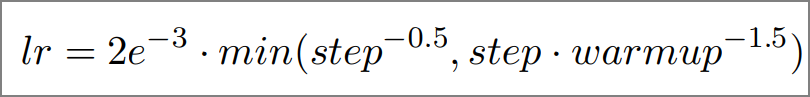

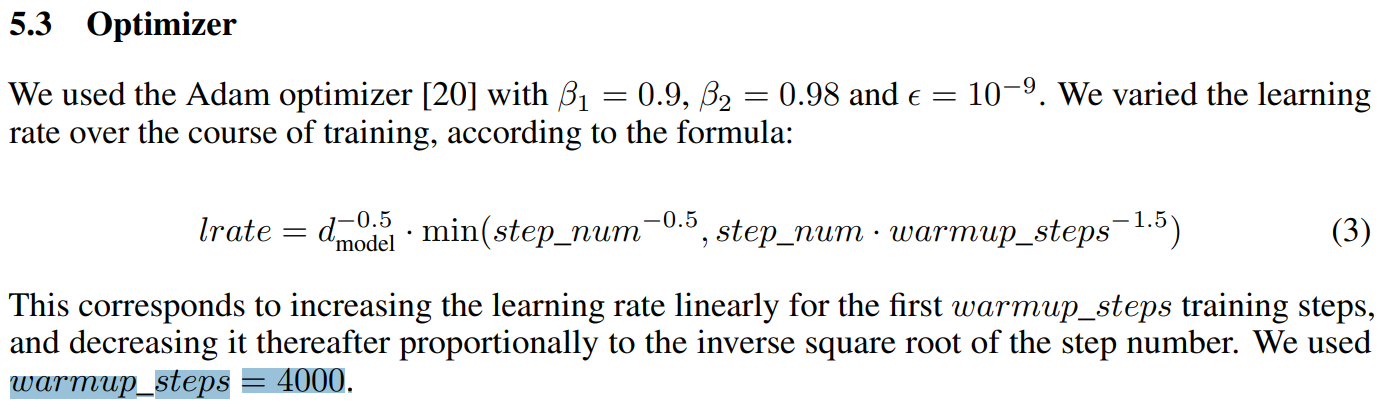

## train

In [ ]:
loss_fct = torch.nn.BCELoss(reduction='none')

# optimizer = Adam(model.parameters(),lr=0.001, betas=(0.9, 0.999))
optimizer = AdamW(model.parameters(),lr=1e-5)


epochs = 15
total_steps = len(train_dataloader) * epochs


print(f'total_steps : {total_steps}')
scheduler = get_linear_schedule_with_warmup(
                                            optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps
                                            )


total_steps : 19950


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch}---------------")
    
    # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
    total_loss, batch_loss, batch_count = 0,0,0
    epoch_rouge1_f, epoch_rouge2_f, epoch_rougeL_f, epoch_intersection_score= 0, 0, 0, 0

    # model을 train 모드로 설정 & device 할당
    model.train()
    model.to(device)
    
    # data iterator를 돌면서 하나씩 학습
    for step, batch in enumerate(train_dataloader):
        batch_count += 1
        
        batch_content, batch_label_str = batch[6], batch[7]

        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch[:-2])
        batch_src, batch_segs, batch_mask_src, batch_clss, batch_mask_cls, batch_labels = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

        # batch마다 모델이 갖고 있는 기존 gradient를 초기화
        model.zero_grad()

        # forward
        sent_scores, mask_cls = model(batch_src, batch_segs, batch_mask_src, batch_clss, batch_mask_cls)

        # loss
        loss = loss_fct(sent_scores, batch_labels.to(torch.float32))
        loss = loss.sum() / loss.numel()
        batch_loss += loss.item()
        total_loss += loss.item()

        # backward -> 파라미터의 미분(gradient)를 자동으로 계산
        loss.backward()

        # gradient clipping 적용 (max_norm = 1)
        clip_grad_norm_(model.parameters(), max_norm=1)
        
        # optimizer & scheduler 업데이트
        optimizer.step()
        scheduler.step()
        
        # Rouge 계산
        sent_score_ampl = (sent_scores + mask_cls.float()).cpu().data.numpy()
        selected_ids = np.argsort(-sent_score_ampl, 1)
        batch_rouge1_f, batch_rouge2_f, batch_rougeL_f, batch_intersection_score = get_score(scorer, batch_content, selected_ids, batch_label_str, batch_labels)
        
        epoch_rouge1_f += batch_rouge1_f
        epoch_rouge2_f += batch_rouge2_f
        epoch_rougeL_f += batch_rougeL_f

        # 배치카운트 100 때마다 평균 loss와 lr를 출력
        if (step % 100 == 0 and step != 0):
            learning_rate = optimizer.param_groups[0]['lr']
            print(f"Step : {step}, LR : {learning_rate:.8f}, Batch Loss(avg) : {batch_loss / batch_count:.8f}")

            # reset 
            batch_loss, batch_count = 0,0

    # 에폭 에러
    print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.8f}, rouge1f : {epoch_rouge1_f / len(train_df):.4f}, rouge2f : {epoch_rouge2_f / len(train_df):.4f}, rougeLf : {epoch_rougeL_f / len(train_df):.4f}")
    # epoch_mean_losses.append(total_loss/(step+1))

Epoch 0---------------
Step : 100, LR : 0.00000995, Batch Loss(avg) : 0.27672900
Step : 200, LR : 0.00000990, Batch Loss(avg) : 0.25331994
Step : 300, LR : 0.00000985, Batch Loss(avg) : 0.23621955
Step : 400, LR : 0.00000980, Batch Loss(avg) : 0.23094441
Step : 500, LR : 0.00000975, Batch Loss(avg) : 0.22897764
Step : 600, LR : 0.00000970, Batch Loss(avg) : 0.22386703
Step : 700, LR : 0.00000965, Batch Loss(avg) : 0.21724649
Step : 800, LR : 0.00000960, Batch Loss(avg) : 0.20994771
Step : 900, LR : 0.00000955, Batch Loss(avg) : 0.21604711
Step : 1000, LR : 0.00000950, Batch Loss(avg) : 0.21078410
Step : 1100, LR : 0.00000945, Batch Loss(avg) : 0.21373837
Step : 1200, LR : 0.00000940, Batch Loss(avg) : 0.20707559
Step : 1300, LR : 0.00000935, Batch Loss(avg) : 0.20767711
Epoch 0 Total Mean Loss : 0.22529483, rouge1f : 0.6523, rouge2f : 0.4739, rougeLf : 0.6110
Epoch 1---------------
Step : 100, LR : 0.00000928, Batch Loss(avg) : 0.18521193
Step : 200, LR : 0.00000923, Batch Loss(avg) : 

In [ ]:
# 모델 저장
def save_checkpoint(path, model, optimizer, scheduler, fold_i, epoch, loss):
    file_name = f'{path}/model_{fold_i}.ckpt.{epoch}'
    
    # torch.save 함수 참고
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}\n")

In [ ]:
save_checkpoint(version, model, optimizer, scheduler, 1, epoch, loss)
# save_checkpoint(path, model, optimizer, scheduler, fold_i, epoch, total_loss)

Saving epoch 14 checkpoint at v05/model_1.ckpt.14



# Dev 검증

## 모델 불러오기

In [ ]:
checkpoint = torch.load(f'{version}/model_1.ckpt.14')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## dev_loader

In [ ]:
dev_df

,index,TITLE,CONTENT,LABEL,SUMMARY_IDX,SUMMARY_ONEHOT_IDX,LABEL_CNT,src,new_idx,seg,mask_src,clss,mask_cls
0,0.0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,"[0, 9, 11]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",3.0,"[2, 4227, 20212, 12, 24697, 13, 7084, 7330, 63...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38, 64, 77, 87, 126, 138, 156, 185, 198, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1.0,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,"[0, 8, 12]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7084, 7330, 2145, 1726, 2160, 9583, 17482,...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 20, 45, 68, 92, 105, 124, 140, 169, 200, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2.0,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"[0, 1, 8]","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 1244, 4161, 2052, 3670, 31302, 2119, 1537,...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 22, 62, 72, 99, 113, 128, 154, 164, 191, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3.0,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,"[0, 21, 25]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"[2, 1929, 13744, 1757, 1469, 2472, 5367, 2264,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 21, 39, 53, 71, 78, 106, 135, 162, 190, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4.0,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"[2, 3, 12]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7992, 12731, 2116, 1244, 4161, 7446, 11300...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 14, 25, 55, 85, 95, 135, 144, 162, 190, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996.0,"[현장목소리] 울산 만나는 김상식 감독, “벼랑 끝 심정, 위기이자 기회다”",전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다.\t전북...,전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다.\t김상...,"[0, 9, 17]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",3.0,"[2, 6275, 3845, 8008, 2096, 3871, 2052, 4595, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 24, 56, 76, 83, 95, 117, 138, 156, 175, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1996,1997.0,“크로스 올리면 네이마르보다 위협적”… ‘리그 4골’ 공격수 품은 이유,FC 바르셀로나 로날드 쿠만 감독이 신입생 루크 데 용을 품은 이유를 밝혔다.\t바...,바르사는 이적 시장 마지막 날에 데 용을 데려왔다.\t하지만 쿠만 감독은 데 용 활...,"[1, 8, 12]","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.0,"[2, 7992, 12731, 991, 18508, 1738, 2154, 3871,...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 23, 39, 65, 81, 98, 115, 141, 153, 171, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1997,1998.0,"[현장목소리] 홍명보 감독, “전북 상대로 우리 경쟁력 가늠할 경기”",울산 현대 홍명보 감독이 전북 현대와 103번째 현대가더비를 반드시 승리하겠다고 밝...,"사전 기자회견에 나선 홍명보 감독은 ""우리도 전북도 굉장히

In [ ]:
dev_dataset = CustomDataset(
                              dev_df['src'].tolist(),
                              dev_df['seg'].tolist(), 
                              dev_df['mask_src'].tolist(),
                              dev_df['clss'].tolist(), 
                              dev_df['mask_cls'].tolist(),
                              dev_df['new_idx'].tolist(),
                              dev_df['CONTENT'].tolist(),
                              dev_df['LABEL'].tolist()
                              )

In [ ]:
dev_dataloader = DataLoader(dev_dataset, batch_size=8, collate_fn=custom_collate_fn, shuffle=False)

In [ ]:
model.eval()

pred = []
for step, batch in enumerate(dev_dataloader):

    batch_content, batch_label_str = batch[6], batch[7]

    # tensor 연산 전, 각 tensor에 device 할당
    batch = tuple(item.to(device) for item in batch[:-2])
        
    batch_src, batch_segs, batch_mask_src, batch_clss, batch_mask_cls, batch_labels = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]
    
    # gradient 계산하지 않고 forward 진행
    with torch.no_grad():
        sent_scores, mask_cls = model(batch_src, batch_segs, batch_mask_src, batch_clss, batch_mask_cls)

    sent_score_ampl = (sent_scores + mask_cls.float()).cpu().data.numpy()
    selected_ids = np.argsort(-sent_score_ampl, 1)
    pred_strings = get_pred_str(scorer, batch_content, selected_ids, batch_label_str, batch_labels)

    pred.extend(pred_strings)


In [ ]:
dev_df['PREDICT SUMMARY'] = pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dev_df.rename(columns = {'TRUE_SUMMARY':'LABEL'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


중간에 예측 dataframe을 저장하였음

In [ ]:
dev_df.to_csv('dev_df.csv')

저장된것 불러오기

In [ ]:
test_df = pd.read_csv('test_df.csv')
test_df.head(3)

,Unnamed: 0,TITLE,CONTENT,PUBLISH_DT,LABEL,SUMMARY_ONEHOT_IDX,src,new_idx,seg,mask_src,clss,mask_cls,SAMMARY,PREDICT SUMMARY
0,0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,2021-07-15,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 4227, 20212, 12, 24697, 13, 7084, 7330, 63...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38, 64, 77, 87, 126, 138, 156, 185, 198, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마...
1,1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,2021-07-15,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 7084, 7330, 2145, 1726, 2160, 9583, 17482,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 20, 45, 68, 92, 105, 124, 140, 169, 200, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",이탈리아는 UEFA가 선정한 베스트11에 5명이나 이름을 올렸다. 공식 베스트11...,이탈리아는 UEFA가 선정한 베스트11에 5명이나 이름을 올렸다. 공식 베스트11...
2,2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,2021-07-15,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 1244, 4161, 2052, 3670, 31302, 2119, 1537,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 22, 62, 72, 99, 113, 128, 154, 164, 191, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","슈퍼컴퓨터가 예상한 TOP4는 맨시티를 포함해 리버풀, 첼시, 맨유 순이었다. 새...","슈퍼컴퓨터가 예상한 TOP4는 맨시티를 포함해 리버풀, 첼시, 맨유 순이었다. 새..."


In [ ]:
dev_df = dev_df.fillna('')  # LABEL에 nan값이 있어서 빈 문자열로 채웠음

In [ ]:
dev_df = dev_df[['TITLE', 'CONTENT', 'LABEL', 'PREDICT SUMMARY']]
dev_df

,TITLE,CONTENT,LABEL,PREDICT SUMMARY
0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마...
1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,이탈리아는 UEFA가 선정한 베스트11에 5명이나 이름을 올렸다. 공식 베스트11...
2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"슈퍼컴퓨터가 예상한 TOP4는 맨시티를 포함해 리버풀, 첼시, 맨유 순이었다. 새..."
3,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,1995년부터 1999년까지 마인츠에서 왼쪽 풀백으로 활약한 스토버 디렉터는 이재...
4,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다. 바르사 공식 스토어는 ""이번 ..."
...,...,...,...,...
1995,"[현장목소리] 울산 만나는 김상식 감독, “벼랑 끝 심정, 위기이자 기회다”",전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다.\t전북...,전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다.\t김상...,전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다. 김상...
1996,“크로스 올리면 네이마르보다 위협적”… ‘리그 4골’ 공격수 품은 이유,FC 바르셀로나 로날드 쿠만 감독이 신입생 루크 데 용을 품은 이유를 밝혔다.\t바...,바르사는 이적 시장 마지막 날에 데 용을 데려왔다.\t하지만 쿠만 감독은 데 용 활...,바르사는 이적 시장 마지막 날에 데 용을 데려왔다. 하지만 쿠만 감독은 데 용 활...
1997,"[현장목소리] 홍명보 감독, “전북 상대로 우리 경쟁력 가늠할 경기”",울산 현대 홍명보 감독이 전북 현대와 103번째 현대가더비를 반드시 승리하겠다고 밝...,"사전 기자회견에 나선 홍명보 감독은 ""우리도 전북도 굉장히 중요한 경기다.\t지난 ...","사전 기자회견에 나선 홍명보 감독은 ""우리도 전북도 굉장히 중요한 경기다. 전북을..."
1998,"루크 더 용, 메시 라커룸 자리 물려받았다...'알 수 없는 압박감'",루크 더 용(바르셀로나)이 이전에 리오넬 메시(파리 생제르맹)가 쓰던 라커룸 자리를...,루크 더 용(바르셀로나)이 이전에 리오넬 메시(파리 생제르맹)가 쓰던 라커룸 자리를...,"영국 매체 '트리뷰나'는 10일(한국시간) ""더 용은 메시가 떠난 라커룸 빈 자리..."


In [ ]:
scorer = RougeScorer()  # 아래 RougeScorer 선언부분 실행하고 오기
scores = scorer.compute_rouge(dev_df, 'd')

scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TITLE,CONTENT,LABEL,PREDICT SUMMARY,SCORE
0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마...,1.000000
1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,이탈리아는 UEFA가 선정한 베스트11에 5명이나 이름을 올렸다. 공식 베스트11...,0.747475
2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"슈퍼컴퓨터가 예상한 TOP4는 맨시티를 포함해 리버풀, 첼시, 맨유 순이었다. 새...",1.000000
3,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,1995년부터 1999년까지 마인츠에서 왼쪽 풀백으로 활약한 스토버 디렉터는 이재...,0.814815
4,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다. 바르사 공식 스토어는 ""이번 ...",0.263158
...,...,...,...,...,...
1995,"[현장목소리] 울산 만나는 김상식 감독, “벼랑 끝 심정, 위기이자 기회다”",전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다.\t전북...,전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다.\t김상...,전북 현대 김상식 감독이 울산 현대와 103번째 현대가더비 승리를 다짐했다. 김상...,1.000000
1996,“크로스 올리면 네이마르보다 위협적”… ‘리그 4골’ 공격수 품은 이유,FC 바르셀로나 로날드 쿠만 감독이 신입생 루크 데 용을 품은 이유를 밝혔다.\t바...,바르사는 이적 시장 마지막 날에 데 용을 데려왔다.\t하지만 쿠만 감독은 데 용 활...,바르사는 이적 시장 마지막 날에 데 용을 데려왔다. 하지만 쿠만 감독은 데 용 활...,0.653465
1997,"[현장목소리] 홍명보 감독, “전북 상대로 우리 경쟁력 가늠할 경기”",울산 현대 홍명보 감독이 전북 현대와 103번째 현대가더비를 반드시 승리하겠다고 밝...,"사전 기자회견에 나선 홍명보 감독은 ""우리도 전북도 굉장히 중요한 경기다.\t지난 ...","사전 기자회견에 나선 홍명보 감독은 ""우리도 전북도 굉장히 중요한 경기다. 전북을...",0.414815
1998,"루크 더 용, 메시 라커룸 자리 물려받았다...'알 수 없는 압박감'",루크 더 용(바르셀로나)이 이전에 리오넬 메시(파리 생제르맹)가 쓰던 라커룸 자리를...,루크 더 용(바르셀로나)이 이전에 리오넬 메시(파리 생제르맹)가 쓰던 라커룸 자리를...,"영국 매체 '트리뷰나'는 10일(한국시간) ""더 용은 메시가 떠난 라커룸 빈 자리...",1.000000


In [ ]:
scores['SCORE'].mean()

0.7855541429049939

# 추론하기(제출파일 만들기)

In [ ]:
test_df = pd.read_csv('sports_news_submission_format.csv')
test_df

,TITLE,CONTENT,PUBLISH_DT,TRUE_SUMMARY
0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,2021-07-15,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...
1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,2021-07-15,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...
2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,2021-07-15,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...
3,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,2021-07-15,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...
4,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,2021-07-15,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...
...,...,...,...,...
9070,"이제 홈팬 야유 받는 먹튀 선수, 차비 감독 조차 “그만 해라”",FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는 밉상이 되어버렸다.\t바르사는...,2022-02-07,FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는 밉상이 되어버렸다.\t그는 경...
9071,"[오피셜] 성남, 만 17세 유스 김지수와 준프로 계약",성남FC가 만17세 2004년생 수비수 김지수와 준프로 계약을 체결했다.\t김지수는...,2022-02-07,성남FC가 만17세 2004년생 수비수 김지수와 준프로 계약을 체결했다.\tU15 ...
9072,"오베르마스, 아약스서 쫓겨난다...'여성 동료들에게 부적절한 메시지'",'레전드' 마르크 오베르마스가 아약스에서 쫓겨났다.\t이유는 굉장히 굴욕적이었다.\...,2022-02-07,'레전드' 마르크 오베르마스가 아약스에서 쫓겨났다.\t그런데 최근 오베르마스는 부적...
9073,"바르사 차비 감독, 트라오레 데뷔전 활약에 깜짝...""몸이 야수 같아""",FC 바르셀로나 차비 에르난데스 감독이 데뷔전을 치른 아다마 트라오레를 극찬했다.\...,2022-02-07,FC 바르셀로나 차비 에르난데스 감독이 데뷔전을 치른 아다마 트라오레를 극찬했다.\...


In [ ]:
test_df['SUMMARY_ONEHOT_IDX'] = f'{[0] * 512}'  # 문장으로만 예측하기 위해 정답 라벨은 아무 값이나 넣음
test_df['SUMMARY_ONEHOT_IDX'] = test_df['SUMMARY_ONEHOT_IDX'].map(lambda x: eval(x))

In [ ]:
src = []
new_idx = []
seg = []
for _ in range(test_df.shape[0]):
    src_one, new_idx_one, seg_one = get_src_new_idx(test_df.loc[_]['CONTENT'], test_df.loc[_]['SUMMARY_ONEHOT_IDX'])
    src.append(src_one)
    new_idx.append(new_idx_one)
    seg.append(seg_one)

In [ ]:
test_df['src'] = src
test_df['new_idx'] = new_idx
test_df['seg'] = seg

In [ ]:
test_df['mask_src'] = test_df['src'].map(lambda x: [1] * len(x))

In [ ]:
test_df['clss'] = test_df['src'].map(lambda x: [ti for ti, t in enumerate(x) if t == tokenizer.cls_token_id])
test_df['mask_cls'] = test_df['clss'].map(lambda x: [1] * len(x))

In [ ]:
test_df

,TITLE,CONTENT,PUBLISH_DT,TRUE_SUMMARY,SUMMARY_ONEHOT_IDX,src,new_idx,seg,mask_src,clss,mask_cls
0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,2021-07-15,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 4227, 20212, 12, 24697, 13, 7084, 7330, 63...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38, 64, 77, 87, 126, 138, 156, 185, 198, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,2021-07-15,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 7084, 7330, 2145, 1726, 2160, 9583, 17482,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 20, 45, 68, 92, 105, 124, 140, 169, 200, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,2021-07-15,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 1244, 4161, 2052, 3670, 31302, 2119, 1537,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 22, 62, 72, 99, 113, 128, 154, 164, 191, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,2021-07-15,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 1929, 13744, 1757, 1469, 2472, 5367, 2264,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 21, 39, 53, 71, 78, 106, 135, 162, 190, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,2021-07-15,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 7992, 12731, 2116, 1244, 4161, 7446, 11300...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 14, 25, 55, 85, 95, 135, 144, 162, 190, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...
9070,"이제 홈팬 야유 받는 먹튀 선수, 차비 감독 조차 “그만 해라”",FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는 밉상이 되어버렸다.\t바르사는...,2022-02-07,FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는 밉상이 되어버렸다.\t그는 경...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 7992, 23746, 12721, 12, 4547, 5957, 2063, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 25, 74, 89, 102, 119, 137, 151, 182, 189, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
9071,"[오피셜] 성남, 만 17세 유스 김지수와 준프로 계약",성남FC가 만17세 2004년생 수비수 김지수와 준프로 계약을 체결했다.\t김지수는...,2022-02-07,성남FC가 만17세 2004년생 수비수 김지수와 준프로 계약을 체결했다.\tU15 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 6406, 10904, 2116, 1038, 20835, 2103, 5764...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 23, 55, 92, 166, 222, 245, 265, 298, 337, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
9072,"오베르마스, 아약스서 쫓겨난다...'여성 동료들에게 부적절한 메시지'",'레전드' 마르크 오베르마스가 아약스에서 쫓겨났다.\t이유는 굉장히 굴욕적이었다.\...,2022-02-07,'레전드' 마르크 오베르마스가 아약스에서 쫓겨났다.\t그런데 최근 오베르마스는 부적...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 11, 21443, 11, 25678, 1443, 11842, 6931, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0

예측할 데이터(라벨없음) 완성되었음

In [ ]:
test_dataset = CustomDataset(
                              test_df['src'].tolist(),
                              test_df['seg'].tolist(), 
                              test_df['mask_src'].tolist(),
                              test_df['clss'].tolist(), 
                              test_df['mask_cls'].tolist(),
                              test_df['new_idx'].tolist(),
                              test_df['CONTENT'].tolist(),
                              test_df['TRUE_SUMMARY'].tolist()
                              )

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=custom_collate_fn, shuffle=False)

In [ ]:
# 요약(예측) 문장 얻기.

def get_pred_str(scorer, batch_content, selected_ids, batch_label_str, batch_labels):  # 배치만큼 계산

    pred_strings = []
    for doc, pred_idxs, true_str, true_positions in zip(batch_content, selected_ids, batch_label_str, batch_labels):
        # true_positions = true_positions.detach().cpu().numpy()
        # nof_labels = true_positions.sum()
        # if nof_labels == 0:
        #     # print(f'label개수 0!!!')
        #     continue

        if len(doc.split('\t')) <= 2:  # 문장 개수가 2 이하이면 문장 개수만큼만 예측하기
            pred_idxs = pred_idxs[:len(doc.split('\t'))]
        else:
            pred_idxs = pred_idxs[:3]

        pred_str = ''
        for pi in pred_idxs:
            if pi in range(len(doc.split('\t'))):  # 예측한 index가 문장의 수보다 크게 나올수도 있음. 이 경우를 제거함. 예)문장수 10, 정답인덱스 18
                pred_str = pred_str + ' ' + np.array(doc.split('\t'))[pi]
        pred_strings.append(pred_str)


    return pred_strings

In [ ]:
model.eval()

pred = []
for step, batch in enumerate(test_dataloader):

    batch_content, batch_label_str = batch[6], batch[7]

    # tensor 연산 전, 각 tensor에 device 할당
    batch = tuple(item.to(device) for item in batch[:-2])
        
    batch_src, batch_segs, batch_mask_src, batch_clss, batch_mask_cls, batch_labels = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]
    
    # gradient 계산하지 않고 forward 진행
    with torch.no_grad():
        sent_scores, mask_cls = model(batch_src, batch_segs, batch_mask_src, batch_clss, batch_mask_cls)

    sent_score_ampl = (sent_scores + mask_cls.float()).cpu().data.numpy()
    selected_ids = np.argsort(-sent_score_ampl, 1)
    pred_strings = get_pred_str(scorer, batch_content, selected_ids, batch_label_str, batch_labels)

    pred.extend(pred_strings)


In [ ]:
test_df['PREDICT SUMMARY'] = pred

In [ ]:
test_df.rename(columns = {'TRUE_SUMMARY':'LABEL'},inplace=True)

중간에 예측 dataframe을 저장하였음

In [ ]:
test_df.to_csv('test_df.csv')

저장된것 불러오기

In [ ]:
test_df = pd.read_csv('test_df.csv')
test_df.head(3)

,Unnamed: 0,TITLE,CONTENT,PUBLISH_DT,LABEL,SUMMARY_ONEHOT_IDX,src,new_idx,seg,mask_src,clss,mask_cls,SAMMARY,PREDICT SUMMARY
0,0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,2021-07-15,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 4227, 20212, 12, 24697, 13, 7084, 7330, 63...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 38, 64, 77, 87, 126, 138, 156, 185, 198, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마...
1,1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,2021-07-15,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 7084, 7330, 2145, 1726, 2160, 9583, 17482,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 20, 45, 68, 92, 105, 124, 140, 169, 200, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",이탈리아는 UEFA가 선정한 베스트11에 5명이나 이름을 올렸다. 공식 베스트11...,이탈리아는 UEFA가 선정한 베스트11에 5명이나 이름을 올렸다. 공식 베스트11...
2,2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,2021-07-15,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 1244, 4161, 2052, 3670, 31302, 2119, 1537,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 22, 62, 72, 99, 113, 128, 154, 164, 191, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","슈퍼컴퓨터가 예상한 TOP4는 맨시티를 포함해 리버풀, 첼시, 맨유 순이었다. 새...","슈퍼컴퓨터가 예상한 TOP4는 맨시티를 포함해 리버풀, 첼시, 맨유 순이었다. 새..."


In [ ]:
test_df = test_df.fillna('')  # LABEL에 nan값이 있어서 빈 문자열로 채웠음

In [ ]:
test_df = test_df[['TITLE', 'CONTENT', 'PUBLISH_DT', 'LABEL', 'PREDICT SUMMARY']]
test_df

,TITLE,CONTENT,PUBLISH_DT,LABEL,PREDICT SUMMARY
0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,2021-07-15,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마...
1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,2021-07-15,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,이탈리아는 UEFA가 선정한 베스트11에 5명이나 이름을 올렸다. 공식 베스트11...
2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,2021-07-15,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"슈퍼컴퓨터가 예상한 TOP4는 맨시티를 포함해 리버풀, 첼시, 맨유 순이었다. 새..."
3,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,2021-07-15,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,1995년부터 1999년까지 마인츠에서 왼쪽 풀백으로 활약한 스토버 디렉터는 이재...
4,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,2021-07-15,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다. 바르사 공식 스토어는 ""이번 ..."
...,...,...,...,...,...
9070,"이제 홈팬 야유 받는 먹튀 선수, 차비 감독 조차 “그만 해라”",FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는 밉상이 되어버렸다.\t바르사는...,2022-02-07,FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는 밉상이 되어버렸다.\t그는 경...,뎀벨레는 바르사 시절 내내 잦은 부상과 부진으로 제 몫을 해내지 못했다. FC바르...
9071,"[오피셜] 성남, 만 17세 유스 김지수와 준프로 계약",성남FC가 만17세 2004년생 수비수 김지수와 준프로 계약을 체결했다.\t김지수는...,2022-02-07,성남FC가 만17세 2004년생 수비수 김지수와 준프로 계약을 체결했다.\tU15 ...,"U15 크로아티아 국제 축구대회와 AFC U16 챔피언십 예선 참여, 2021년 ..."
9072,"오베르마스, 아약스서 쫓겨난다...'여성 동료들에게 부적절한 메시지'",'레전드' 마르크 오베르마스가 아약스에서 쫓겨났다.\t이유는 굉장히 굴욕적이었다.\...,2022-02-07,'레전드' 마르크 오베르마스가 아약스에서 쫓겨났다.\t그런데 최근 오베르마스는 부적...,장기간에 걸쳐 여성 동료들에게 부적절한 메시지를 계속 보냈고 결국 사건이 수면 위...
9073,"바르사 차비 감독, 트라오레 데뷔전 활약에 깜짝...""몸이 야수 같아""",FC 바르셀로나 차비 에르난데스 감독이 데뷔전을 치른 아다마 트라오레를 극찬했다.\...,2022-02-07,FC 바르셀로나 차비 에르난데스 감독이 데뷔전을 치른 아다마 트라오레를 극찬했다.\...,"트라오레는 지난겨울 이적시장에서 울버햄프턴을 떠나 바르사로 임대 이적했고, 이날 ..."


In [ ]:
scorer = RougeScorer()  # 아래 RougeScorer 선언부분 실행하고 오기
scores = scorer.compute_rouge(test_df, 'd')

scores

,TITLE,CONTENT,PUBLISH_DT,LABEL,PREDICT SUMMARY,SCORE
0,스털링 다이빙 논란 종결?… “오른쪽 다리 접촉 있었잖아”,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,2021-07-15,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마크...,유럽축구연맹(UEFA) 유로 2020 심판위원장 로베르토 로세티가 잉글랜드와 덴마...,1.000000
1,"‘디 마리아 없다’ 유로X코파 베스트11, 이탈리아만 7명",유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t지...,2021-07-15,유로 2020과 코파 아메리카 2021로 베스트11을 만든다면 어떤 모습일까.\t공...,이탈리아는 UEFA가 선정한 베스트11에 5명이나 이름을 올렸다. 공식 베스트11...,0.747475
2,‘슈퍼컴퓨터 예측’ 맨시티 우승-맨유 4위… 토트넘은 ‘6위’,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,2021-07-15,새 시즌이 시작하기도 전에 슈퍼컴퓨터가 예상한 순위가 나왔다.\t영국 매체 '스포츠...,"슈퍼컴퓨터가 예상한 TOP4는 맨시티를 포함해 리버풀, 첼시, 맨유 순이었다. 새...",1.000000
3,"“이재성, 완벽한 프로… 마인츠서 성공할 것” 킬 디렉터의 애정 듬뿍 응원",홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t이재성은 ...,2021-07-15,홀슈타인 킬 우베 스토버 디렉터가 이재성을 향해 응원 메시지를 띄웠다.\t1995년...,1995년부터 1999년까지 마인츠에서 왼쪽 풀백으로 활약한 스토버 디렉터는 이재...,0.814815
4,"‘홈킷과 딴판’ 바르사 팬들, NEW 어웨이 셔츠 호평… “가장 좋아하는 색!”",FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다.\t팬들은 만족스럽다는 반응이다....,2021-07-15,바르사는 15일(한국 시간) 공식 홈페이지를 통해 2021/2022시즌에 입을 어웨...,"FC 바르셀로나가 새 시즌 원정 유니폼을 공개했다. 바르사 공식 스토어는 ""이번 ...",0.263158
...,...,...,...,...,...,...
9070,"이제 홈팬 야유 받는 먹튀 선수, 차비 감독 조차 “그만 해라”",FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는 밉상이 되어버렸다.\t바르사는...,2022-02-07,FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는 밉상이 되어버렸다.\t그는 경...,뎀벨레는 바르사 시절 내내 잦은 부상과 부진으로 제 몫을 해내지 못했다. FC바르...,1.000000
9071,"[오피셜] 성남, 만 17세 유스 김지수와 준프로 계약",성남FC가 만17세 2004년생 수비수 김지수와 준프로 계약을 체결했다.\t김지수는...,2022-02-07,성남FC가 만17세 2004년생 수비수 김지수와 준프로 계약을 체결했다.\tU15 ...,"U15 크로아티아 국제 축구대회와 AFC U16 챔피언십 예선 참여, 2021년 ...",1.000000
9072,"오베르마스, 아약스서 쫓겨난다...'여성 동료들에게 부적절한 메시지'",'레전드' 마르크 오베르마스가 아약스에서 쫓겨났다.\t이유는 굉장히 굴욕적이었다.\...,2022-02-07,'레전드' 마르크 오베르마스가 아약스에서 쫓겨났다.\t그런데 최근 오베르마스는 부적...,장기간에 걸쳐 여성 동료들에게 부적절한 메시지를 계속 보냈고 결국 사건이 수면 위...,1.000000
9073,"바르사 차비 감독, 트라오레 데뷔전 활약에 깜짝...""몸이 야수 같아""",FC 바르셀로나 차비 에르난데스 감독이 데뷔전을 치른 아다마 트라오레를 극찬했다.\...,2022-02-07,FC 바르셀로나 차비 에르난데스 감독이 데뷔전을 치른 아다마 트라오레를 극찬했다.\...,"트라오레는 지난겨울 이적시장에서 울버햄프턴을 떠나 바르사로 임대 이적했고, 이날 ...",1.000000


In [ ]:
scores.to_csv('scores_bertsum.csv')

In [ ]:
print(f'ROUGE1_f1 of BERTSUM : {scores.SCORE.mean()}')

ROUGE1_f1 of BERTSUM : 0.7218603187639476


## RougeScorer 선언

In [ ]:
%%bash
cd /tmp
sudo wget https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
sudo tar xvf mecab-0.996-ko-0.9.2.tar.gz

cd /tmp/mecab-0.996-ko-0.9.2
sudo ./configure
sudo make check
sudo make install

In [ ]:
%%bash
cd /tmp
wget https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
tar zxvf mecab-ko-dic-2.1.1-20180720.tar.gz

cd /tmp/mecab-ko-dic-2.1.1-20180720
sudo ./autogen.sh
sudo ./configure
sudo make
sudo make install

In [ ]:
%%bash
cd /tmp
git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
cd mecab-python-0.996
python3 setup.py build
python3 setup.py install

In [ ]:
!pip install konlpy

In [ ]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
import konlpy
from konlpy.tag import Mecab

In [ ]:
import os
import re
import platform
import itertools
import collections
import pkg_resources  # pip install py-rouge
from io import open


if platform.system() == "Windows":
    try:
        from eunjeon import Mecab
    except:
        print("please install eunjeon module")
else:  # Ubuntu일 경우
    from konlpy.tag import Mecab




class Rouge:
    DEFAULT_METRICS = {"rouge-n"}
    DEFAULT_N = 1
    STATS = ["f", "p", "r"]
    AVAILABLE_METRICS = {"rouge-n", "rouge-l", "rouge-w"}
    AVAILABLE_LENGTH_LIMIT_TYPES = {"words", "bytes"}
    REMOVE_CHAR_PATTERN = re.compile("[^A-Za-z0-9가-힣]")


    def __init__(
        self,
        metrics=None,
        max_n=None,
        limit_length=True,
        length_limit=1000,
        length_limit_type="words",
        apply_avg=True,
        apply_best=False,
        use_tokenizer=True,
        alpha=0.5,
        weight_factor=1.0,
    ):
        self.metrics = metrics[:] if metrics is not None else Rouge.DEFAULT_METRICS
        for m in self.metrics:
            if m not in Rouge.AVAILABLE_METRICS:
                raise ValueError("Unknown metric '{}'".format(m))


        self.max_n = max_n if "rouge-n" in self.metrics else None
        # Add all rouge-n metrics
        if self.max_n is not None:
            index_rouge_n = self.metrics.index("rouge-n")
            del self.metrics[index_rouge_n]
            self.metrics += ["rouge-{}".format(n) for n in range(1, self.max_n + 1)]
        self.metrics = set(self.metrics)


        self.limit_length = limit_length
        if self.limit_length:
            if length_limit_type not in Rouge.AVAILABLE_LENGTH_LIMIT_TYPES:
                raise ValueError("Unknown length_limit_type '{}'".format(length_limit_type))


        self.length_limit = length_limit
        if self.length_limit == 0:
            self.limit_length = False
        self.length_limit_type = length_limit_type


        self.use_tokenizer = use_tokenizer
        if use_tokenizer:
            self.tokenizer = Mecab()


        self.apply_avg = apply_avg
        self.apply_best = apply_best
        self.alpha = alpha
        self.weight_factor = weight_factor
        if self.weight_factor <= 0:
            raise ValueError("ROUGE-W weight factor must greater than 0.")


    def tokenize_text(self, text):
        if self.use_tokenizer:
            return self.tokenizer.morphs(text)
        else:
            return text


    @staticmethod
    def split_into_sentences(text):
        return text.split("\n")


    @staticmethod
    def _get_ngrams(n, text):
        ngram_set = collections.defaultdict(int)
        max_index_ngram_start = len(text) - n
        for i in range(max_index_ngram_start + 1):
            ngram_set[tuple(text[i : i + n])] += 1
        return ngram_set


    @staticmethod
    def _split_into_words(sentences):
        return list(itertools.chain(*[_.split() for _ in sentences]))


    @staticmethod
    def _get_word_ngrams_and_length(n, sentences):
        assert len(sentences) > 0
        assert n > 0


        tokens = Rouge._split_into_words(sentences)
        return Rouge._get_ngrams(n, tokens), tokens, len(tokens) - (n - 1)


    @staticmethod
    def _get_unigrams(sentences):
        assert len(sentences) > 0


        tokens = Rouge._split_into_words(sentences)
        unigram_set = collections.defaultdict(int)
        for token in tokens:
            unigram_set[token] += 1
        return unigram_set, len(tokens)


    @staticmethod
    def _compute_p_r_f_score(
        evaluated_count,
        reference_count,
        overlapping_count,
        alpha=0.5,
        weight_factor=1.0,
    ):
        precision = 0.0 if evaluated_count == 0 else overlapping_count / float(evaluated_count)
        if weight_factor != 1.0:
            precision = precision ** (1.0 / weight_factor)
        recall = 0.0 if reference_count == 0 else overlapping_count / float(reference_count)
        if weight_factor != 1.0:
            recall = recall ** (1.0 / weight_factor)
        f1_score = Rouge._compute_f_score(precision, recall, alpha)
        return {"f": f1_score, "p": precision, "r": recall}


    @staticmethod
    def _compute_f_score(precision, recall, alpha=0.5):
        return (
            0.0
            if (recall == 0.0 or precision == 0.0)
            else precision * recall / ((1 - alpha) * precision + alpha * recall)
        )


    @staticmethod
    def _compute_ngrams(evaluated_sentences, reference_sentences, n):
        if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
            raise ValueError("Collections must contain at least 1 sentence.")


        evaluated_ngrams, _, evaluated_count = Rouge._get_word_ngrams_and_length(
            n, evaluated_sentences
        )
        reference_ngrams, _, reference_count = Rouge._get_word_ngrams_and_length(
            n, reference_sentences
        )


        # Gets the overlapping ngrams between evaluated and reference
        overlapping_ngrams = set(evaluated_ngrams.keys()).intersection(set(reference_ngrams.keys()))
        overlapping_count = 0
        for ngram in overlapping_ngrams:
            overlapping_count += min(evaluated_ngrams[ngram], reference_ngrams[ngram])


        return evaluated_count, reference_count, overlapping_count


    @staticmethod
    def _compute_ngrams_lcs(evaluated_sentences, reference_sentences, weight_factor=1.0):
        def _lcs(x, y):
            m = len(x)
            n = len(y)
            vals = collections.defaultdict(int)
            dirs = collections.defaultdict(int)


            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if x[i - 1] == y[j - 1]:
                        vals[i, j] = vals[i - 1, j - 1] + 1
                        dirs[i, j] = "|"
                    elif vals[i - 1, j] >= vals[i, j - 1]:
                        vals[i, j] = vals[i - 1, j]
                        dirs[i, j] = "^"
                    else:
                        vals[i, j] = vals[i, j - 1]
                        dirs[i, j] = "<"


            return vals, dirs


        def _wlcs(x, y, weight_factor):
            m = len(x)
            n = len(y)
            vals = collections.defaultdict(float)
            dirs = collections.defaultdict(int)
            lengths = collections.defaultdict(int)


            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if x[i - 1] == y[j - 1]:
                        length_tmp = lengths[i - 1, j - 1]
                        vals[i, j] = (
                            vals[i - 1, j - 1]
                            + (length_tmp + 1) ** weight_factor
                            - length_tmp ** weight_factor
                        )
                        dirs[i, j] = "|"
                        lengths[i, j] = length_tmp + 1
                    elif vals[i - 1, j] >= vals[i, j - 1]:
                        vals[i, j] = vals[i - 1, j]
                        dirs[i, j] = "^"
                        lengths[i, j] = 0
                    else:
                        vals[i, j] = vals[i, j - 1]
                        dirs[i, j] = "<"
                        lengths[i, j] = 0


            return vals, dirs


        def _mark_lcs(mask, dirs, m, n):
            while m != 0 and n != 0:
                if dirs[m, n] == "|":
                    m -= 1
                    n -= 1
                    mask[m] = 1
                elif dirs[m, n] == "^":
                    m -= 1
                elif dirs[m, n] == "<":
                    n -= 1
                else:
                    raise UnboundLocalError("Illegal move")


            return mask


        if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
            raise ValueError("Collections must contain at least 1 sentence.")


        evaluated_unigrams_dict, evaluated_count = Rouge._get_unigrams(evaluated_sentences)
        reference_unigrams_dict, reference_count = Rouge._get_unigrams(reference_sentences)


        # Has to use weight factor for WLCS
        use_WLCS = weight_factor != 1.0
        if use_WLCS:
            evaluated_count = evaluated_count ** weight_factor
            reference_count = 0


        overlapping_count = 0.0
        for reference_sentence in reference_sentences:
            reference_sentence_tokens = reference_sentence.split()
            if use_WLCS:
                reference_count += len(reference_sentence_tokens) ** weight_factor
            hit_mask = [0 for _ in range(len(reference_sentence_tokens))]


            for evaluated_sentence in evaluated_sentences:
                evaluated_sentence_tokens = evaluated_sentence.split()


                if use_WLCS:
                    _, lcs_dirs = _wlcs(
                        reference_sentence_tokens,
                        evaluated_sentence_tokens,
                        weight_factor,
                    )
                else:
                    _, lcs_dirs = _lcs(reference_sentence_tokens, evaluated_sentence_tokens)
                _mark_lcs(
                    hit_mask,
                    lcs_dirs,
                    len(reference_sentence_tokens),
                    len(evaluated_sentence_tokens),
                )


            overlapping_count_length = 0
            for ref_token_id, val in enumerate(hit_mask):
                if val == 1:
                    token = reference_sentence_tokens[ref_token_id]
                    if evaluated_unigrams_dict[token] > 0 and reference_unigrams_dict[token] > 0:
                        evaluated_unigrams_dict[token] -= 1
                        reference_unigrams_dict[ref_token_id] -= 1


                        if use_WLCS:
                            overlapping_count_length += 1
                            if (
                                ref_token_id + 1 < len(hit_mask) and hit_mask[ref_token_id + 1] == 0
                            ) or ref_token_id + 1 == len(hit_mask):
                                overlapping_count += overlapping_count_length ** weight_factor
                                overlapping_count_length = 0
                        else:
                            overlapping_count += 1


        if use_WLCS:
            reference_count = reference_count ** weight_factor


        return evaluated_count, reference_count, overlapping_count


    def get_scores(self, hypothesis, references):
        if isinstance(hypothesis, str):
            hypothesis, references = [hypothesis], [references]


        if type(hypothesis) != type(references):
            raise ValueError("'hyps' and 'refs' are not of the same type")


        if len(hypothesis) != len(references):
            raise ValueError("'hyps' and 'refs' do not have the same length")
        scores = {}
        has_rouge_n_metric = (
            len([metric for metric in self.metrics if metric.split("-")[-1].isdigit()]) > 0
        )
        if has_rouge_n_metric:
            scores.update(self._get_scores_rouge_n(hypothesis, references))
            # scores = {**scores, **self._get_scores_rouge_n(hypothesis, references)}


        has_rouge_l_metric = (
            len([metric for metric in self.metrics if metric.split("-")[-1].lower() == "l"]) > 0
        )
        if has_rouge_l_metric:
            scores.update(self._get_scores_rouge_l_or_w(hypothesis, references, False))
            # scores = {**scores, **self._get_scores_rouge_l_or_w(hypothesis, references, False)}


        has_rouge_w_metric = (
            len([metric for metric in self.metrics if metric.split("-")[-1].lower() == "w"]) > 0
        )
        if has_rouge_w_metric:
            scores.update(self._get_scores_rouge_l_or_w(hypothesis, references, True))
            # scores = {**scores, **self._get_scores_rouge_l_or_w(hypothesis, references, True)}


        return scores


    def _get_scores_rouge_n(self, all_hypothesis, all_references):
        metrics = [metric for metric in self.metrics if metric.split("-")[-1].isdigit()]


        if self.apply_avg or self.apply_best:
            scores = {metric: {stat: 0.0 for stat in Rouge.STATS} for metric in metrics}
        else:
            scores = {
                metric: [{stat: [] for stat in Rouge.STATS} for _ in range(len(all_hypothesis))]
                for metric in metrics
            }


        for sample_id, (hypothesis, references) in enumerate(zip(all_hypothesis, all_references)):
            assert isinstance(hypothesis, str)
            has_multiple_references = False
            if isinstance(references, list):
                has_multiple_references = len(references) > 1
                if not has_multiple_references:
                    references = references[0]


            # Prepare hypothesis and reference(s)
            hypothesis = self._preprocess_summary_as_a_whole(hypothesis)
            references = (
                [self._preprocess_summary_as_a_whole(reference) for reference in references]
                if has_multiple_references
                else [self._preprocess_summary_as_a_whole(references)]
            )


            # Compute scores
            for metric in metrics:
                suffix = metric.split("-")[-1]
                n = int(suffix)


                # Aggregate
                if self.apply_avg:
                    # average model
                    total_hypothesis_ngrams_count = 0
                    total_reference_ngrams_count = 0
                    total_ngrams_overlapping_count = 0


                    for reference in references:
                        (
                            hypothesis_count,
                            reference_count,
                            overlapping_ngrams,
                        ) = Rouge._compute_ngrams(hypothesis, reference, n)
                        total_hypothesis_ngrams_count += hypothesis_count
                        total_reference_ngrams_count += reference_count
                        total_ngrams_overlapping_count += overlapping_ngrams


                    score = Rouge._compute_p_r_f_score(
                        total_hypothesis_ngrams_count,
                        total_reference_ngrams_count,
                        total_ngrams_overlapping_count,
                        self.alpha,
                    )


                    for stat in Rouge.STATS:
                        scores[metric][stat] += score[stat]
                else:
                    # Best model
                    if self.apply_best:
                        best_current_score = None
                        for reference in references:
                            (
                                hypothesis_count,
                                reference_count,
                                overlapping_ngrams,
                            ) = Rouge._compute_ngrams(hypothesis, reference, n)
                            score = Rouge._compute_p_r_f_score(
                                hypothesis_count,
                                reference_count,
                                overlapping_ngrams,
                                self.alpha,
                            )
                            if best_current_score is None or score["r"] > best_current_score["r"]:
                                best_current_score = score


                        for stat in Rouge.STATS:
                            scores[metric][stat] += best_current_score[stat]
                    # Keep all
                    else:
                        for reference in references:
                            (
                                hypothesis_count,
                                reference_count,
                                overlapping_ngrams,
                            ) = Rouge._compute_ngrams(hypothesis, reference, n)
                            score = Rouge._compute_p_r_f_score(
                                hypothesis_count,
                                reference_count,
                                overlapping_ngrams,
                                self.alpha,
                            )
                            for stat in Rouge.STATS:
                                scores[metric][sample_id][stat].append(score[stat])


        # Compute final score with the average or the the max
        if (self.apply_avg or self.apply_best) and len(all_hypothesis) > 1:
            for metric in metrics:
                for stat in Rouge.STATS:
                    scores[metric][stat] /= len(all_hypothesis)


        return scores


    def _get_scores_rouge_l_or_w(self, all_hypothesis, all_references, use_w=False):
        metric = "rouge-w" if use_w else "rouge-l"
        if self.apply_avg or self.apply_best:
            scores = {metric: {stat: 0.0 for stat in Rouge.STATS}}
        else:
            scores = {
                metric: [{stat: [] for stat in Rouge.STATS} for _ in range(len(all_hypothesis))]
            }


        for sample_id, (hypothesis_sentences, references_sentences) in enumerate(
            zip(all_hypothesis, all_references)
        ):
            assert isinstance(hypothesis_sentences, str)
            has_multiple_references = False
            if isinstance(references_sentences, list):
                has_multiple_references = len(references_sentences) > 1
                if not has_multiple_references:
                    references_sentences = references_sentences[0]


            # Prepare hypothesis and reference(s)
            hypothesis_sentences = self._preprocess_summary_per_sentence(hypothesis_sentences)
            references_sentences = (
                [
                    self._preprocess_summary_per_sentence(reference)
                    for reference in references_sentences
                ]
                if has_multiple_references
                else [self._preprocess_summary_per_sentence(references_sentences)]
            )


            # Compute scores
            # Aggregate
            if self.apply_avg:
                # average model
                total_hypothesis_ngrams_count = 0
                total_reference_ngrams_count = 0
                total_ngrams_overlapping_count = 0


                for reference_sentences in references_sentences:
                    (
                        hypothesis_count,
                        reference_count,
                        overlapping_ngrams,
                    ) = Rouge._compute_ngrams_lcs(
                        hypothesis_sentences,
                        reference_sentences,
                        self.weight_factor if use_w else 1.0,
                    )
                    total_hypothesis_ngrams_count += hypothesis_count
                    total_reference_ngrams_count += reference_count
                    total_ngrams_overlapping_count += overlapping_ngrams


                score = Rouge._compute_p_r_f_score(
                    total_hypothesis_ngrams_count,
                    total_reference_ngrams_count,
                    total_ngrams_overlapping_count,
                    self.alpha,
                    self.weight_factor if use_w else 1.0,
                )
                for stat in Rouge.STATS:
                    scores[metric][stat] += score[stat]
            else:
                # Best model
                if self.apply_best:
                    best_current_score = None
                    best_current_score_wlcs = None
                    for reference_sentences in references_sentences:
                        (
                            hypothesis_count,
                            reference_count,
                            overlapping_ngrams,
                        ) = Rouge._compute_ngrams_lcs(
                            hypothesis_sentences,
                            reference_sentences,
                            self.weight_factor if use_w else 1.0,
                        )
                        score = Rouge._compute_p_r_f_score(
                            total_hypothesis_ngrams_count,
                            total_reference_ngrams_count,
                            total_ngrams_overlapping_count,
                            self.alpha,
                            self.weight_factor if use_w else 1.0,
                        )


                        if use_w:
                            reference_count_for_score = reference_count ** (
                                1.0 / self.weight_factor
                            )
                            overlapping_ngrams_for_score = overlapping_ngrams
                            score_wlcs = (
                                overlapping_ngrams_for_score / reference_count_for_score
                            ) ** (1.0 / self.weight_factor)


                            if (
                                best_current_score_wlcs is None
                                or score_wlcs > best_current_score_wlcs
                            ):
                                best_current_score = score
                                best_current_score_wlcs = score_wlcs
                        else:
                            if best_current_score is None or score["r"] > best_current_score["r"]:
                                best_current_score = score


                    for stat in Rouge.STATS:
                        scores[metric][stat] += best_current_score[stat]
                # Keep all
                else:
                    for reference_sentences in references_sentences:
                        (
                            hypothesis_count,
                            reference_count,
                            overlapping_ngrams,
                        ) = Rouge._compute_ngrams_lcs(
                            hypothesis_sentences,
                            reference_sentences,
                            self.weight_factor if use_w else 1.0,
                        )
                        score = Rouge._compute_p_r_f_score(
                            hypothesis_count,
                            reference_count,
                            overlapping_ngrams,
                            self.alpha,
                            self.weight_factor,
                        )


                        for stat in Rouge.STATS:
                            scores[metric][sample_id][stat].append(score[stat])


        # Compute final score with the average or the the max
        if (self.apply_avg or self.apply_best) and len(all_hypothesis) > 1:
            for stat in Rouge.STATS:
                scores[metric][stat] /= len(all_hypothesis)


        return scores


    def _preprocess_summary_as_a_whole(self, summary):
        sentences = Rouge.split_into_sentences(summary)


        # Truncate
        if self.limit_length:
            # By words
            if self.length_limit_type == "words":
                summary = " ".join(sentences)
                all_tokens = summary.split()  # Counting as in the perls script
                summary = " ".join(all_tokens[: self.length_limit])


            # By bytes
            elif self.length_limit_type == "bytes":
                summary = ""
                current_len = 0
                for sentence in sentences:
                    sentence = sentence.strip()
                    sentence_len = len(sentence)


                    if current_len + sentence_len < self.length_limit:
                        if current_len != 0:
                            summary += " "
                        summary += sentence
                        current_len += sentence_len
                    else:
                        if current_len > 0:
                            summary += " "
                        summary += sentence[: self.length_limit - current_len]
                        break
        else:
            summary = " ".join(sentences)


        summary = Rouge.REMOVE_CHAR_PATTERN.sub(" ", summary.lower()).strip()


        tokens = self.tokenize_text(Rouge.REMOVE_CHAR_PATTERN.sub(" ", summary))
        preprocessed_summary = [" ".join(tokens)]


        return preprocessed_summary


    def _preprocess_summary_per_sentence(self, summary):
        sentences = Rouge.split_into_sentences(summary)


        # Truncate
        if self.limit_length:
            final_sentences = []
            current_len = 0
            # By words
            if self.length_limit_type == "words":
                for sentence in sentences:
                    tokens = sentence.strip().split()
                    tokens_len = len(tokens)
                    if current_len + tokens_len < self.length_limit:
                        sentence = " ".join(tokens)
                        final_sentences.append(sentence)
                        current_len += tokens_len
                    else:
                        sentence = " ".join(tokens[: self.length_limit - current_len])
                        final_sentences.append(sentence)
                        break
            # By bytes
            elif self.length_limit_type == "bytes":
                for sentence in sentences:
                    sentence = sentence.strip()
                    sentence_len = len(sentence)
                    if current_len + sentence_len < self.length_limit:
                        final_sentences.append(sentence)
                        current_len += sentence_len
                    else:
                        sentence = sentence[: self.length_limit - current_len]
                        final_sentences.append(sentence)
                        break
            sentences = final_sentences


        final_sentences = []
        for sentence in sentences:
            sentence = Rouge.REMOVE_CHAR_PATTERN.sub(" ", sentence.lower()).strip()


            tokens = self.tokenize_text(Rouge.REMOVE_CHAR_PATTERN.sub(" ", sentence))


            sentence = " ".join(tokens)


            final_sentences.append(sentence)


        return final_sentences

In [ ]:
import argparse
import pandas as pd
from tqdm import tqdm

class RougeScorer:
    def __init__(self):
        self.rouge_evaluator = Rouge(
            metrics=["rouge-n", "rouge-l"],
            max_n=2,
            limit_length=True,
            length_limit=1000,
            length_limit_type="words",
            use_tokenizer=True,
            apply_avg=True,
            apply_best=False,
            alpha=0.5,  # Default F1_score
            weight_factor=1.2,
        )

    def compute_rouge(self, d, ty):
        #ref_df = pd.read_csv(ref_path)
        #hyp_df = pd.read_csv(hyp_path)
        hyp_df = pd.DataFrame(d['PREDICT SUMMARY'])
        hyp_df['id'] = d.index
        ref_df = pd.DataFrame(d['LABEL'])
        ref_df['id'] = d.index

        hyp_df.iloc[:,0] = hyp_df.iloc[:,0].fillna(' ')
        ids = ref_df.index
        hyp_df = hyp_df[hyp_df['id'].isin(ids)]
        hyp_df.index = ref_df.index


        ref_df["id"] = ref_df["id"].astype(int)
        hyp_df["id"] = hyp_df["id"].astype(int)

        hyps = [tuple(row) for row in hyp_df.values]
        refs = [tuple(row) for row in ref_df.values]

        reference_summaries = []
        generated_summaries = []

        for ref_tp, hyp_tp in zip(refs, hyps):
            ref, ref_id = ref_tp
            hyp, hyp_id = hyp_tp

            assert ref_id == hyp_id

            reference_summaries.append(ref)
            generated_summaries.append(hyp)

        scores = self.rouge_evaluator.get_scores(generated_summaries, reference_summaries)
        str_scores = self.format_rouge_scores(scores)
        #self.save_rouge_scores(str_scores)


        scores = []

        for i in range(len(reference_summaries)):
            score = self.rouge_evaluator.get_scores(generated_summaries[i], reference_summaries[i])
            scores.append(score["rouge-1"]["f"])
        #self.save_rouge_scores(str_scores)
        d['SCORE'] = scores
        
        if ty == 'd':
            return d
        elif ty == 'A':
            return str_scores

    def save_rouge_scores(self, str_scores):
        with open("rouge_scores.txt", "w") as output:
            output.write(str_scores)

    def format_rouge_scores(self, scores):
    	return "{:.3f},{:.3f},{:.3f}".format(
            scores["rouge-1"]["f"],
            scores["rouge-2"]["f"],
            scores["rouge-l"]["f"],
        )

# (부록) 원본 코드의 데이터생김새 파싱

## 시험

In [ ]:
for batch in train_dataloader:
    # inputs, batch_clss = batch[0]
    break

In [ ]:
batch = tuple(item.to(device) for item in batch)

In [ ]:
sent_scores, mask_cls = model(batch[0], batch[1], batch[2], batch[3], batch[4])

In [ ]:
mask_cls

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
sent_scores

tensor([[0.4998, 0.1079, 0.2082, 0.2029, 0.1263, 0.4264, 0.2778, 0.1369, 0.8368,
         0.5035, 0.4993, 0.2240, 0.4408, 0.2286, 0.1797, 0.2203, 0.1650, 0.0973,
         0.6015, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4298, 0.1027, 0.2317, 0.1450, 0.4336, 0.2018, 0.3463, 0.1272, 0.2558,
         0.2139, 0.1514, 0.1397, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7998, 0.6991, 0.3814, 0.6640, 0.5869, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5336, 0.2687, 0.3248, 0.1962, 0.2781, 0.1589, 0.2399, 0.2900, 0.4282,
         0.3844, 0.1824, 0.2030, 0.1412, 0.1398, 0.1872, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4079, 0.1201, 0.1623, 0.1688, 0.1049, 0.1602, 0.1364, 0.3109, 0.1725,
         0.1800, 0.3470, 0.3222, 0.0865, 0.1141, 0.2581, 0.1031, 0.3690

In [ ]:
loss_fnc = torch.nn.BCELoss(reduction='none')

In [ ]:
batch[5]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
src_sent_labels_list = taorch.tensor(src_sent_labels_list)

ValueError: ignored

In [ ]:
loss = loss_fnc(sent_scores, batch[5].float())

In [ ]:
loss.sum() / loss.numel() 

tensor(0.2583, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
corpus_type = 'train'
bert_data_path = '../bert_data_new/cnndm'


In [ ]:
cnndm.test.0.bert.pt
pts = sorted(glob.glob(bert_data_path + '.' + corpus_type + '.[0-9]*.pt'))

In [ ]:
import glob

In [ ]:
pts = sorted(glob.glob('cnndm.test.0.bert.pt'))

In [ ]:
dataset = torch.load(pts[0])

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
type(dataset)

list

In [ ]:
len(dataset)

2001

In [ ]:
type(dataset[0])

dict

In [ ]:
dataset[0].keys()

dict_keys(['src', 'tgt', 'src_sent_labels', 'segs', 'clss', 'src_txt', 'tgt_txt'])

In [ ]:
print(dataset[0]['src'][:50])

[101, 1037, 2118, 1997, 5947, 3076, 2038, 2351, 3053, 2093, 2706, 2044, 1037, 2991, 1999, 4199, 1999, 1037, 6878, 13742, 2886, 1999, 4199, 1012, 102, 101, 4080, 9587, 29076, 1010, 2322, 1010, 2013, 8904, 3449, 9644, 1010, 4307, 1010, 2018, 2069, 2074, 3369, 2005, 1037, 13609, 2565, 1999, 3304, 2043]


In [ ]:
dataset[0]['src'][25]

101

In [ ]:
tokenizer.decode(dataset[0]['src'])

"[CLS] a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome. [SEP] [CLS] andrew mogni, 20, from glen ellyn, illinois, had only just arrived for a semester program in italy when the incident happened in january. [SEP] [CLS] he was flown back to chicago via air ambulance on march 20, but he died on sunday. [SEP] [CLS] andrew mogni, 20, from glen ellyn, illinois, a university of iowa student has died nearly three months after a fall in rome in a suspected robbery [SEP] [CLS] he was taken to a medical facility in the chicago area, close to his family home in glen ellyn. [SEP] [CLS] he died on sunday at northwestern memorial hospital - medical examiner's office spokesman frank shuftan says a cause of death won't be released until monday at the earliest. [SEP] [CLS] initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed. [SEP] [CLS] on sunday, his cousin 

In [ ]:
tokenizer.decode(dataset[0]['tgt'])

'[unused0] andrew mogni, 20, from glen ellyn, illinois, had only just arrived for a semester program when the incident happened in january [unused2] he was flown back to chicago via air on march 20 but he died on sunday [unused2] initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed [unused2] his cousin claims he was attacked and thrown 40ft from a bridge [unused1]'

In [ ]:
dataset[0]['src_sent_labels']

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
print(dataset[0]['segs'][:30])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [ ]:
last = 30
i = 0
for token, seg in zip(dataset[0]['src'][:], dataset[0]['segs'][:]):
    print(f'idx : {i:2}, word : {tokenizer.decode([token]):10}, token id : {token:5}, segment : {seg}')
    i += 1

idx :  0, word : [CLS]     , token id :   101, segment : 0
idx :  1, word : a         , token id :  1037, segment : 0
idx :  2, word : university, token id :  2118, segment : 0
idx :  3, word : of        , token id :  1997, segment : 0
idx :  4, word : iowa      , token id :  5947, segment : 0
idx :  5, word : student   , token id :  3076, segment : 0
idx :  6, word : has       , token id :  2038, segment : 0
idx :  7, word : died      , token id :  2351, segment : 0
idx :  8, word : nearly    , token id :  3053, segment : 0
idx :  9, word : three     , token id :  2093, segment : 0
idx : 10, word : months    , token id :  2706, segment : 0
idx : 11, word : after     , token id :  2044, segment : 0
idx : 12, word : a         , token id :  1037, segment : 0
idx : 13, word : fall      , token id :  2991, segment : 0
idx : 14, word : in        , token id :  1999, segment : 0
idx : 15, word : rome      , token id :  4199, segment : 0
idx : 16, word : in        , token id :  1999, segment :

In [ ]:
dataset[0]['clss']

[0,
 25,
 57,
 78,
 112,
 136,
 174,
 197,
 223,
 245,
 285,
 301,
 337,
 358,
 382,
 416,
 452]

In [ ]:
dataset[0]['src_txt']

['a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome .',
 'andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program in italy when the incident happened in january .',
 'he was flown back to chicago via air ambulance on march 20 , but he died on sunday .',
 'andrew mogni , 20 , from glen ellyn , illinois , a university of iowa student has died nearly three months after a fall in rome in a suspected robbery',
 'he was taken to a medical facility in the chicago area , close to his family home in glen ellyn .',
 "he died on sunday at northwestern memorial hospital - medical examiner 's office spokesman frank shuftan says a cause of death wo n't be released until monday at the earliest .",
 'initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed .',
 "on sunday , his cousin abby wrote online : ` this morning my cous

In [ ]:
dataset[0]['tgt_txt']

'andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program when the incident happened in january<q>he was flown back to chicago via air on march 20 but he died on sunday<q>initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed<q>his cousin claims he was attacked and thrown 40ft from a bridge'

In [ ]:
참고 
        with torch.no_grad():
            for batch in valid_iter:
                src = batch.src
                labels = batch.src_sent_labels
                segs = batch.segs
                clss = batch.clss
                mask = batch.mask_src
                mask_cls = batch.mask_cls

                sent_scores, mask = self.model(src, segs, clss, mask, mask_cls)

                loss = self.loss(sent_scores, labels.float())
                loss = (loss * mask.float()).sum()
                batch_stats = Statistics(float(loss.cpu().data.numpy()), len(labels))
                stats.update(batch_stats)
            self._report_step(0, step, valid_stats=stats)

In [ ]:
tokenizer.decode([2])

'[unused1]'

In [ ]:
    def preprocess(self, ex, is_test):
        src = ex['src']
        tgt = ex['tgt'][:self.args.max_tgt_len][:-1]+[2]
        src_sent_labels = ex['src_sent_labels']
        segs = ex['segs']
        if(not self.args.use_interval):
            segs=[0]*len(segs)
        clss = ex['clss']
        src_txt = ex['src_txt']
        tgt_txt = ex['tgt_txt']

        end_id = [src[-1]]
        src = src[:-1][:self.args.max_pos - 1] + end_id
        segs = segs[:self.args.max_pos]
        max_sent_id = bisect.bisect_left(clss, self.args.max_pos)
        src_sent_labels = src_sent_labels[:max_sent_id]
        clss = clss[:max_sent_id]
        # src_txt = src_txt[:max_sent_id]



        if(is_test):
            return src, tgt, segs, clss, src_sent_labels, src_txt, tgt_txt
        else:
            return src, tgt, segs, clss, src_sent_labels

In [ ]:
ex = dataset[0]
type(ex)

dict

In [ ]:
src = ex['src']
src

In [ ]:
ex['tgt'][:140]

In [ ]:
tgt = ex['tgt'][:140][:-1]+[2]
tokenizer.decode(tgt)

'[unused0] andrew mogni, 20, from glen ellyn, illinois, had only just arrived for a semester program when the incident happened in january [unused2] he was flown back to chicago via air on march 20 but he died on sunday [unused2] initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed [unused2] his cousin claims he was attacked and thrown 40ft from a bridge [unused1]'

In [ ]:
src_sent_labels = ex['src_sent_labels']
src_sent_labels

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
segs = ex['segs']
segs

In [ ]:
clss = ex['clss']
clss

[0,
 25,
 57,
 78,
 112,
 136,
 174,
 197,
 223,
 245,
 285,
 301,
 337,
 358,
 382,
 416,
 452]

In [ ]:
src_txt = ex['src_txt']
tgt_txt = ex['tgt_txt']

In [ ]:
import bisect
end_id = [src[-1]]
src = src[:-1][:512 - 1] + end_id  # 마지막 하나 떼어내고 sep 붙이기
segs = segs[:512]
max_sent_id = bisect.bisect_left(clss, 512)
src_sent_labels = src_sent_labels[:max_sent_id]
clss = clss[:max_sent_id]


In [ ]:
end_id

[102]

In [ ]:
tokenizer.decode(end_id)

'[SEP]'

In [ ]:
tokenizer.decode(src)

"[CLS] a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome. [SEP] [CLS] andrew mogni, 20, from glen ellyn, illinois, had only just arrived for a semester program in italy when the incident happened in january. [SEP] [CLS] he was flown back to chicago via air ambulance on march 20, but he died on sunday. [SEP] [CLS] andrew mogni, 20, from glen ellyn, illinois, a university of iowa student has died nearly three months after a fall in rome in a suspected robbery [SEP] [CLS] he was taken to a medical facility in the chicago area, close to his family home in glen ellyn. [SEP] [CLS] he died on sunday at northwestern memorial hospital - medical examiner's office spokesman frank shuftan says a cause of death won't be released until monday at the earliest. [SEP] [CLS] initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed. [SEP] [CLS] on sunday, his cousin 

In [ ]:
clss

[0,
 25,
 57,
 78,
 112,
 136,
 174,
 197,
 223,
 245,
 285,
 301,
 337,
 358,
 382,
 416,
 452]

In [ ]:
max_sent_id

17

In [ ]:
src_sent_labels

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
clss

[0,
 25,
 57,
 78,
 112,
 136,
 174,
 197,
 223,
 245,
 285,
 301,
 337,
 358,
 382,
 416,
 452]

In [ ]:
src

479

In [ ]:
tokenizer.decode(src)

"[CLS] a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome. [SEP] [CLS] andrew mogni, 20, from glen ellyn, illinois, had only just arrived for a semester program in italy when the incident happened in january. [SEP] [CLS] he was flown back to chicago via air ambulance on march 20, but he died on sunday. [SEP] [CLS] andrew mogni, 20, from glen ellyn, illinois, a university of iowa student has died nearly three months after a fall in rome in a suspected robbery [SEP] [CLS] he was taken to a medical facility in the chicago area, close to his family home in glen ellyn. [SEP] [CLS] he died on sunday at northwestern memorial hospital - medical examiner's office spokesman frank shuftan says a cause of death won't be released until monday at the earliest. [SEP] [CLS] initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed. [SEP] [CLS] on sunday, his cousin 

In [ ]:
preprocessing 마친 후 : src, tgt, segs, clss, src_sent_labels

모델에 들어가는 형태 : src, segs, clss, mask_src, mask_cls

In [ ]:
pre_src = [src]
pre_tgt = [tgt]
pre_segs = [segs]
pre_clss = [clss]
pre_src_sent_labels = [src_sent_labels]

In [ ]:
def _pad(data, pad_id, width=-1):
    if (width == -1):
        width = 600
    rtn_data = [d + [pad_id] * (width - len(d)) for d in data]
    return rtn_data

In [ ]:
(src == 0)[0]

In [ ]:
mask_src

array([1, 0, 1])

In [ ]:
src

In [ ]:
src = torch.tensor(_pad(pre_src, 0))
tgt = torch.tensor(_pad(pre_tgt, 0))

segs = torch.tensor(_pad(pre_segs, 0))
mask_src = 1 - ([src] == 0)
mask_tgt = 1 - (tgt == 0)


RuntimeError: ignored

In [ ]:
src

tensor([[  101,  1037,  2118,  1997,  5947,  3076,  2038,  2351,  3053,  2093,
          2706,  2044,  1037,  2991,  1999,  4199,  1999,  1037,  6878, 13742,
          2886,  1999,  4199,  1012,   102,   101,  4080,  9587, 29076,  1010,
          2322,  1010,  2013,  8904,  3449,  9644,  1010,  4307,  1010,  2018,
          2069,  2074,  3369,  2005,  1037, 13609,  2565,  1999,  3304,  2043,
          1996,  5043,  3047,  1999,  2254,  1012,   102,   101,  2002,  2001,
         10583,  2067,  2000,  3190,  3081,  2250, 10771,  2006,  2233,  2322,
          1010,  2021,  2002,  2351,  2006,  4465,  1012,   102,   101,  4080,
          9587, 29076,  1010,  2322,  1010,  2013,  8904,  3449,  9644,  1010,
          4307,  1010,  1037,  2118,  1997,  5947,  3076,  2038,  2351,  3053,
          2093,  2706,  2044,  1037,  2991,  1999,  4199,  1999,  1037,  6878,
         13742,   102,   101,  2002,  2001,  2579,  2000,  1037,  2966,  4322,
          1999,  1996,  3190,  2181,  1010,  2485,  

In [ ]:
src == 0

False

In [ ]:
mask_src

1

In [ ]:
loss

In [ ]:
loss.sum() / loss.numel() 

tensor(0.3292, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
for batch in (train_loader):

In [ ]:
input = tokenizer(tokenizer.decode(src), return_tensors='pt')

In [ ]:
type(input)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
len(input['input_ids'][0])

451

In [ ]:
len(input['token_type_ids'][0])

451

In [ ]:
len(input['attention_mask'][0])

451

In [ ]:
len(torch.tensor([src])[0])

449

In [ ]:
len(torch.tensor([segs])[0])

449

In [ ]:
len(torch.tensor([mask_src])[0])

449

In [ ]:
kobert = AutoModel.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
result = kobert(input_ids=torch.tensor([src]), token_type_ids=torch.tensor([segs]), attention_mask=torch.tensor([mask_src]))

In [ ]:
top_vec = result[0]

In [ ]:
top_vec.shape

torch.Size([1, 449, 768])

In [ ]:
torch.arange(top_vec.size(0)).unsqueeze(1)

tensor([[0]])

In [ ]:
clss = indices

In [ ]:
sents_vec = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), clss]

In [ ]:
sents_vec.shape

torch.Size([1, 7, 768])

In [ ]:
mask_cls = [1] * len(clss)
mask_cls = torch.tensor([mask_cls])
mask_cls

tensor([[1, 1, 1, 1, 1, 1, 1]])

In [ ]:
mask_cls[:, :, None].float()

tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]])

In [ ]:
sents_vec = sents_vec * mask_cls[:, :, None].float()

In [ ]:
sents_vec.shape

torch.Size([1, 7, 768])

In [ ]:
linear1 = nn.Linear(kobert.config.hidden_size, 1)
sigmoid = nn.Sigmoid()

In [ ]:
h = linear1(sents_vec).squeeze(-1)
sent_scores = sigmoid(h) * mask_cls.float()

In [ ]:
h

tensor([[0.4164, 0.4756, 0.2549, 0.0744, 0.2729, 0.0902, 0.3366]],
       grad_fn=<SqueezeBackward1>)

In [ ]:
sent_scores

tensor([[0.6026, 0.6167, 0.5634, 0.5186, 0.5678, 0.5225, 0.5834]],
       grad_fn=<MulBackward0>)

In [ ]:
loss_fnc = torch.nn.BCELoss(reduction='none')

In [ ]:
src_sent_labels = [1, 0, 0, 0, 0, 0, 0]

In [ ]:
src_sent_labels = torch.tensor([src_sent_labels])
src_sent_labels.float()

tensor([[1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
loss = loss_fnc(sent_scores, src_sent_labels.float())

In [ ]:
loss.sum() / loss.numel() 

tensor(0.7827, grad_fn=<DivBackward0>)

In [ ]:
(loss.sum() / loss.numel()).backward()

In [ ]:
loss.numel()

7